# Vision Model for Environmental Monitoring (OpenEarthMap)

**Goal:** Train a baseline U-Net and a stronger segmentation model, then compare validation metrics and qualitative results.

**Dataset:** OpenEarthMap - Environmental monitoring with 8 land cover classes.

**Evaluation:** Validation metrics + qualitative test predictions; water/vegetation focus metrics included.

## A) Setup & Imports

**Purpose: Mount Drive and set project paths**
- Setup section: mounts Google Drive for persistent storage
- Defines the project directory used by data preparation and training
- Ensures Colab reads and writes to the same Drive folder


Purpose: Imports required libraries and utilities.
Inputs: none. Outputs: modules available for later cells.


In [ ]:
from pathlib import Path

try:
    import google.colab  # noqa: F401
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_DIR = Path("/content/drive/MyDrive/DL_project")
else:
    PROJECT_DIR = Path.cwd() / "DL_project"

PROJECT_DIR.mkdir(parents=True, exist_ok=True)


Mounted at /content/drive


**Purpose: Prepare optional Colab dependencies**
- Setup section: installs segmentation_models_pytorch and timm if running in Colab
- Uses the runtime environment to decide whether installation is needed
- Ensures pretrained encoder support is available

Purpose: Imports required libraries and utilities.
Inputs: none. Outputs: modules available for later cells.


In [ ]:
# Install dependencies (Colab only)
import importlib.util
import subprocess
import sys


def _ensure_pkg(module_name, pip_name=None):
    if importlib.util.find_spec(module_name) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name or module_name])


try:
    import google.colab  # noqa: F401
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    _ensure_pkg("segmentation_models_pytorch", "segmentation-models-pytorch")
    _ensure_pkg("timm")


**Purpose: Initialize core utilities and reproducibility**
- Setup section: imports PyTorch, image IO, and plotting tools used across the notebook
- Defines a seed helper to control randomness in training and sampling
- Provides shared utilities for later data loading and modeling

Purpose: Imports required libraries and utilities.
Inputs: none. Outputs: modules available for later cells.


In [ ]:
import os
import json
import csv
import time
import random
from pathlib import Path
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from tifffile import imread

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms


def set_seed(seed: int, deterministic: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True


## CONFIG

**Purpose: Define experiment configuration**
- Setup section: sets dataset paths, hyperparameters, and run flags
- Uses GPU availability to choose batch size and AMP settings
- Initializes output directory and device selection

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# CONFIG
DATA_LOCATIONS_PATH = PROJECT_DIR / "data_locations.json"
PREPARED_DIR = PROJECT_DIR / "prepared"
if DATA_LOCATIONS_PATH.exists():
    try:
        data_locations = json.loads(DATA_LOCATIONS_PATH.read_text())
        prepared_dir = data_locations.get("prepared_dir")
        if prepared_dir:
            PREPARED_DIR = Path(prepared_dir).expanduser().resolve()
    except Exception as exc:
        print(f"Warning: could not read data_locations.json: {exc}")

DATA_DIR = PREPARED_DIR

OUTPUTS_DIR = Path("outputs")

# Fixed run settings (Run All)
RUN_BASELINE = True
RUN_IMPROVED = True
IMPROVED_MODEL = "smp_unet_resnet34"

SEED = 42
DETERMINISTIC = True

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 4 if torch.cuda.is_available() else 2
NUM_EPOCHS = 30
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
SCHEDULER = "plateau"  # "plateau" or "cosine"
EARLY_STOPPING_PATIENCE = 8

USE_AMP = True
AMP_ENABLED = USE_AMP and torch.cuda.is_available()

LOSS_MODE = "ce_dice"  # "ce", "ce_dice", "focal", "focal_dice", "tversky", "ce_tversky"
CE_WEIGHT = 1.0
DICE_WEIGHT = 0.5
FOCAL_GAMMA = 2.0
TVERSKY_ALPHA = 0.7
TVERSKY_BETA = 0.3
CLASS_WEIGHTING = "median_freq"  # "median_freq", "log", or "none"

# Set to 0 to avoid multiprocessing errors in Colab
NUM_WORKERS = 0
VAL_EVERY = 1
MAX_TEST_SAMPLES = 1000
QUAL_SAMPLES = 3
SAVE_PRED_MASKS = False

# Set later after class names are loaded
WATER_CLASS = None
VEGETATION_CLASSES = None

OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

set_seed(SEED, deterministic=DETERMINISTIC)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

Device: cuda
GPU: Tesla T4
CUDA version: 12.6


## B) Data Loading & Augmentation

**Purpose: Resolve dataset directories**
- Data loading section: finds the dataset root from DATA_DIR
- Uses folder structure to set image, label, and split paths
- Produces IMAGES_DIR, LABEL_DIR, and SPLITS_DIR for later use

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
DATA_ROOT = DATA_DIR.resolve()
PREPARED_DIR = DATA_ROOT
IMAGES_DIR = PREPARED_DIR / "images"
LABEL_DIR = PREPARED_DIR / "masks"
SPLITS_DIR = PREPARED_DIR / "splits"
INFER_IMAGES_DIR = IMAGES_DIR / "infer_test"
LABELS_ARE_INDEX = True
DATA_MODE = "prepared"

print(f"Using PREPARED dataset: {PREPARED_DIR}")
print(f"Images directory: {IMAGES_DIR}")
print(f"Labels directory: {LABEL_DIR}")
print(f"Splits directory: {SPLITS_DIR}")


Using PREPARED dataset: /content/drive/MyDrive/DL_project/prepared
Images directory: /content/drive/MyDrive/DL_project/prepared/images
Labels directory: /content/drive/MyDrive/DL_project/prepared/masks
Splits directory: /content/drive/MyDrive/DL_project/prepared/splits


**Purpose: Declare segmentation classes and palette**
- Data loading section: defines CLASS_NAMES and CLASS_COLORS for OpenEarthMap
- Builds RGB-to-class mappings used for label conversion
- Provides NUM_CLASSES for model configuration

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Class definitions (defaults)
CLASS_COLORS = {
    0: (128, 0, 0),      # Bareland - #800000
    1: (0, 255, 36),     # Rangeland - #00FF24
    2: (148, 148, 148),  # Developed space - #949494
    3: (255, 255, 255),  # Road - #FFFFFF
    4: (34, 97, 38),     # Tree - #226126
    5: (0, 69, 255),     # Water - #0045FF
    6: (75, 181, 73),    # Agriculture land - #4BB549
    7: (222, 31, 7),     # Building - #DE1F07
}

CLASS_NAMES = ["Bareland", "Rangeland", "Developed", "Road", "Tree", "Water", "Agriculture", "Building"]
NUM_CLASSES = len(CLASS_NAMES)

IGNORE_INDEX = 255

# Load class metadata + normalization from prepared dataset if available
NORM_MEAN = None
NORM_STD = None
METADATA_PATH = DATA_ROOT / "metadata.json"
if DATA_MODE == "prepared" and not METADATA_PATH.exists():
    METADATA_PATH = DATA_ROOT / "meta.json"

if DATA_MODE == "prepared" and METADATA_PATH.exists():
    meta = json.loads(METADATA_PATH.read_text())
    if "class_names" in meta:
        CLASS_NAMES = meta["class_names"]
    if "class_colors" in meta:
        CLASS_COLORS = {int(k): tuple(v) for k, v in meta["class_colors"].items()}
    NUM_CLASSES = int(meta.get("num_classes", len(CLASS_NAMES)))
    norm = meta.get("normalization", {})
    if "mean" in norm and "std" in norm:
        NORM_MEAN = norm["mean"]
        NORM_STD = norm["std"]
    print(f"Loaded prepared metadata from {METADATA_PATH}")

missing = [i for i in range(NUM_CLASSES) if i not in CLASS_COLORS]
if missing:
    raise ValueError(f"CLASS_COLORS missing entries for class indices: {missing}")
RGB_TO_CLASS = {tuple(rgb): idx for idx, rgb in CLASS_COLORS.items()}


def load_label_raw(path: Path) -> np.ndarray:
    img = Image.open(path)
    mode = img.mode
    if mode in ("P", "L"):
        return np.array(img, dtype=np.uint8)
    if mode == "RGB":
        return np.array(img, dtype=np.uint8)
    print(f"Warning: unexpected label mode {mode}; converting to 'L'.")
    return np.array(img.convert("L"), dtype=np.uint8)


def decode_rgb_to_ids(label_rgb: np.ndarray) -> np.ndarray:
    rgb = np.asarray(label_rgb)
    if rgb.ndim == 3 and rgb.shape[2] > 3:
        rgb = rgb[:, :, :3]
    ids = np.full(rgb.shape[:2], IGNORE_INDEX, dtype=np.int64)
    for idx, color in CLASS_COLORS.items():
        mask = np.all(rgb == np.array(color, dtype=np.uint8), axis=-1)
        ids[mask] = idx
    unknown = np.unique(rgb[ids == IGNORE_INDEX].reshape(-1, 3), axis=0)
    if unknown.size:
        print(f"Warning: unknown label colors (first 5): {unknown[:5].tolist()}")
    return ids


def to_train_ids(label_raw: np.ndarray) -> np.ndarray:
    arr = np.asarray(label_raw)
    if arr.ndim == 3:
        if arr.shape[2] == 3 and np.array_equal(arr[:, :, 0], arr[:, :, 1]) and np.array_equal(arr[:, :, 1], arr[:, :, 2]):
            ids = arr[:, :, 0].astype(np.int64)
        else:
            ids = decode_rgb_to_ids(arr).astype(np.int64)
    else:
        ids = arr.astype(np.int64)

    valid = (ids >= 0) & (ids < NUM_CLASSES)
    if IGNORE_INDEX is not None:
        valid |= (ids == IGNORE_INDEX)

    if not np.all(valid):
        bad_vals = np.unique(ids[~valid]).tolist()
        print(f"Warning: unexpected label values (first 10): {bad_vals[:10]}")
        ids = ids.copy()
        ids[~valid] = IGNORE_INDEX

    return ids.astype(np.uint8)



def encode_ids_to_rgb(mask_ids: np.ndarray, class_colors=CLASS_COLORS, ignore_index=IGNORE_INDEX, ignore_color=(0, 0, 0)) -> np.ndarray:
    ids = np.asarray(mask_ids)
    if ids.ndim == 3 and ids.shape[2] == 1:
        ids = ids[:, :, 0]
    ids = ids.astype(np.int64)
    h, w = ids.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for idx, color in class_colors.items():
        rgb[ids == idx] = np.array(color, dtype=np.uint8)
    if ignore_index is not None:
        rgb[ids == ignore_index] = np.array(ignore_color, dtype=np.uint8)
    return rgb


def make_legend(ax, class_names, class_colors, present_ids=None, loc="upper right", fontsize=7):
    handles = []
    for idx, name in enumerate(class_names):
        if idx not in class_colors:
            continue
        if present_ids is not None and idx not in present_ids:
            continue
        color = np.array(class_colors[idx], dtype=np.float32) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{idx}: {name}"))
    if handles:
        ax.legend(handles=handles, fontsize=fontsize, loc=loc, framealpha=0.9)

print(f"Number of classes: {NUM_CLASSES}")
print("Class mapping:")
for idx, name in enumerate(CLASS_NAMES):
    rgb = CLASS_COLORS[idx]
    hex_color = f"#{rgb[0]:02X}{rgb[1]:02X}{rgb[2]:02X}"
    print(f"  {idx}: {name:15s} RGB{rgb} {hex_color}")

if WATER_CLASS is None:
    WATER_CLASS = CLASS_NAMES.index("Water") if "Water" in CLASS_NAMES else 5
if VEGETATION_CLASSES is None:
    VEGETATION_CLASSES = [
        CLASS_NAMES.index(name)
        for name in ["Rangeland", "Tree", "Agriculture"]
        if name in CLASS_NAMES
    ]

print("\nEnvironmental monitoring classes:")
print(f"  Water (class {WATER_CLASS}): RGB{CLASS_COLORS[WATER_CLASS]}")
print(f"  Vegetation classes: {VEGETATION_CLASSES}")


Loaded prepared metadata from /content/drive/MyDrive/DL_project/prepared/metadata.json
Number of classes: 8
Class mapping:
  0: Bareland        RGB(128, 0, 0) #800000
  1: Rangeland       RGB(0, 255, 36) #00FF24
  2: Developed       RGB(148, 148, 148) #949494
  3: Road            RGB(255, 255, 255) #FFFFFF
  4: Tree            RGB(34, 97, 38) #226126
  5: Water           RGB(0, 69, 255) #0045FF
  6: Agriculture     RGB(75, 181, 73) #4BB549
  7: Building        RGB(222, 31, 7) #DE1F07

Environmental monitoring classes:
  Water (class 5): RGB(0, 69, 255)
  Vegetation classes: [1, 4, 6]


**Purpose: Read dataset splits**
- Data loading section: reads train/val/test file names from split text files
- Uses SPLITS_DIR to locate the lists
- Outputs train_files, val_files, and test_files

Purpose: Defines helper function(s) like `load_split_list`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
# Load split file lists
def load_split_list(txt_path: Path) -> list:
    """Load filenames from a .txt file."""
    with open(txt_path, "r") as f:
        files = [line.strip() for line in f if line.strip()]
    return files


train_files = load_split_list(SPLITS_DIR / "train_labeled.txt")
val_files = load_split_list(SPLITS_DIR / "val_labeled.txt")
test_files = load_split_list(SPLITS_DIR / "test_labeled.txt")

infer_test_files = []
infer_split_path = SPLITS_DIR / "infer_test.txt"
if infer_split_path.exists():
    infer_test_files = load_split_list(infer_split_path)

# Reduce test set size (safety guard)
MAX_TEST_SAMPLES = 1000
if len(test_files) > MAX_TEST_SAMPLES:
    original_count = len(test_files)
    test_files = test_files[:MAX_TEST_SAMPLES]
    print(f"Reduced test set from {original_count} to {len(test_files)} samples")

print(f"Train samples: {len(train_files)}")
print(f"Val samples: {len(val_files)}")
print(f"Test samples: {len(test_files)}")
print(f"Infer test samples: {len(infer_test_files)}")


Train samples: 2149
Val samples: 268
Test samples: 270
Infer test samples: 1151


Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
MIN_SAMPLES = 5
assert (IMAGES_DIR / "train").exists(), f"Missing train images dir: {IMAGES_DIR / 'train'}"
assert (IMAGES_DIR / "val").exists(), f"Missing val images dir: {IMAGES_DIR / 'val'}"
assert (IMAGES_DIR / "test").exists(), f"Missing test images dir: {IMAGES_DIR / 'test'}"
assert (LABEL_DIR / "train").exists(), f"Missing train masks dir: {LABEL_DIR / 'train'}"
assert (LABEL_DIR / "val").exists(), f"Missing val masks dir: {LABEL_DIR / 'val'}"
assert (LABEL_DIR / "test").exists(), f"Missing test masks dir: {LABEL_DIR / 'test'}"
assert len(train_files) >= MIN_SAMPLES, "Not enough train samples"
assert len(val_files) >= MIN_SAMPLES, "Not enough val samples"
assert len(test_files) >= MIN_SAMPLES, "Not enough test samples"

if infer_test_files:
    assert INFER_IMAGES_DIR.exists(), f"Missing infer_test images dir: {INFER_IMAGES_DIR}"

sample_name = random.choice(train_files) if train_files else None
if sample_name:
    img_path = IMAGES_DIR / "train" / sample_name
    mask_path = LABEL_DIR / "train" / sample_name
    assert img_path.exists(), f"Missing image: {img_path}"
    assert mask_path.exists(), f"Missing mask: {mask_path}"
    _ = np.array(Image.open(img_path))
    _ = load_label_raw(mask_path)
    print(f"Random sample OK: {sample_name}")


Random sample OK: niamey_11.png


**Purpose: Quick sanity check of prepared splits**
- Data loading section: reports train/val/test counts from split lists
- Loads one sample image and mask from the prepared dataset
- Prints shapes and mask value summary for validation


Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
print("Sanity check: split counts")
print(f"  Train: {len(train_files)}")
print(f"  Val: {len(val_files)}")
print(f"  Test: {len(test_files)}")

sample_name = train_files[0] if len(train_files) > 0 else None
if sample_name is not None:
    img_path = IMAGES_DIR / "train" / sample_name
    mask_path = LABEL_DIR / "train" / sample_name
    if img_path.exists() and mask_path.exists():
        img = np.array(Image.open(str(img_path)))
        mask = load_label_raw(mask_path)
        print(f"Sample: {sample_name}")
        print(f"  Image shape: {img.shape}, dtype: {img.dtype}")
        print(f"  Mask shape: {mask.shape}, dtype: {mask.dtype}")
        if mask.ndim == 2:
            unique_vals = np.unique(mask)
            print(f"  Mask unique values (first 15): {unique_vals[:15].tolist()}")
        elif mask.ndim == 3 and mask.shape[2] == 1:
            unique_vals = np.unique(mask[:, :, 0])
            print(f"  Mask unique values (first 15): {unique_vals[:15].tolist()}")


Sanity check: split counts
  Train: 2149
  Val: 268
  Test: 270
Sample: zanzibar_54.png
  Image shape: (256, 256, 3), dtype: uint8
  Mask shape: (256, 256), dtype: uint8
  Mask unique values (first 15): [1, 4]


Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
ALLOWED_VALUES = set(range(NUM_CLASSES)) | {IGNORE_INDEX}
for split_name, files in [("train", train_files), ("val", val_files), ("test", test_files)]:
    sample = random.sample(files, min(5, len(files)))
    print(f"\n{split_name} samples ({len(sample)}):")
    for fname in sample:
        mask = load_label_raw(LABEL_DIR / split_name / fname)
        if mask.ndim == 3 and mask.shape[2] == 1:
            mask = mask[:, :, 0]
        if mask.ndim != 2:
            raise ValueError(f"Mask {split_name}/{fname} is not 2D: shape={mask.shape}")
        unique_vals = np.unique(mask)
        bad = [int(v) for v in unique_vals if int(v) not in ALLOWED_VALUES]
        print(f"  {fname}: unique (first 15)={unique_vals[:15].tolist()}")
        if bad:
            raise ValueError(f"Mask {split_name}/{fname} has unexpected values: {bad}")



train samples (5):
  dortmund_4.png: unique (first 15)=[1, 2, 3, 4, 5, 6, 7]
  shanghai_9.png: unique (first 15)=[2, 3, 7]
  tonga_68.png: unique (first 15)=[1, 2, 3, 4, 7]
  rio_6.png: unique (first 15)=[0, 1, 2, 3, 4, 5, 7]
  rio_39.png: unique (first 15)=[0, 1, 2, 3, 4, 7, 255]

val samples (5):
  chicago_44.png: unique (first 15)=[1, 2, 3, 4, 7]
  ica_46.png: unique (first 15)=[0, 1, 2, 3, 4, 5, 6, 7, 255]
  aachen_68.png: unique (first 15)=[1, 2, 3, 4, 5, 6, 7]
  monrovia_20.png: unique (first 15)=[1, 2, 3, 4, 7]
  slaskie_21.png: unique (first 15)=[1, 2, 3, 4, 7]

test samples (5):
  kujawsko-pomorskie_5.png: unique (first 15)=[1, 2, 3, 4, 5, 7]
  aachen_12.png: unique (first 15)=[1, 2, 3, 4, 5, 6, 7, 255]
  ngaoundere_67.png: unique (first 15)=[1, 2, 3, 4, 6, 7]
  santiago_67.png: unique (first 15)=[0, 1, 2, 3, 4, 5, 7]
  abancay_37.png: unique (first 15)=[1, 2, 3, 4, 5, 6, 7]


**Purpose: Convert label masks to class indices**
- Data loading section: maps RGB or indexed masks to integer class IDs
- Uses CLASS_COLORS and RGB_TO_CLASS for validation
- Outputs integer masks for training

Purpose: Defines helper function(s) like `rgb_to_class_mask`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
# FIX: Convert label masks to class indices with ignore_index support

def rgb_to_class_mask(label_rgb: np.ndarray) -> np.ndarray:
    """Convert RGB or index mask to training IDs (0..NUM_CLASSES-1, IGNORE_INDEX)."""
    return to_train_ids(label_rgb)


**Purpose: Set image normalization statistics**
- Data loading section: defines ImageNet mean/std for preprocessing
- Used by the dataset to normalize input images
- Keeps preprocessing consistent across models

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Normalization
if NORM_MEAN is None or NORM_STD is None:
    NORM_MEAN = [0.485, 0.456, 0.406]
    NORM_STD = [0.229, 0.224, 0.225]
    NORM_SOURCE = "ImageNet"
else:
    NORM_SOURCE = "prepared metadata"

print(f"Using normalization from {NORM_SOURCE}:")
print(f"  Mean: {NORM_MEAN}")
print(f"  Std: {NORM_STD}")


Using normalization from prepared metadata:
  Mean: [0.4719642996788025, 0.48145806789398193, 0.4312911629676819]
  Std: [0.18355408310890198, 0.163230761885643, 0.17289350926876068]


**Purpose: Define the dataset pipeline**
- Data loading section: loads images and labels from disk with augmentation
- Uses IMAGE_SIZE, class mappings, and normalization settings
- Outputs tensors suitable for the segmentation model

Purpose: Defines helper function(s) like `_to_uint8`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
# Dataset class

def _to_uint8(img: np.ndarray) -> np.ndarray:
    if img.dtype == np.uint8:
        return img
    if np.issubdtype(img.dtype, np.integer):
        max_val = np.iinfo(img.dtype).max
        if max_val > 0:
            img = img.astype(np.float32) / float(max_val) * 255.0
        else:
            img = img.astype(np.float32)
    else:
        if img.max() <= 1.0:
            img = img * 255.0
        elif img.max() > 255.0:
            img = img / img.max() * 255.0
    return np.clip(img, 0, 255).round().astype(np.uint8)


class OpenEarthMapDataset(data.Dataset):
    """PyTorch Dataset for OpenEarthMap semantic segmentation."""

    def __init__(
        self,
        file_list: list,
        images_dir: Path,
        labels_dir: Path = None,
        mode: str = 'train',
        image_size: tuple = (512, 512),
        augment: bool = False
    ):
        self.file_list = file_list
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.mode = mode
        self.image_size = image_size
        self.augment = augment and (mode == 'train')

        # Filter valid files
        self.valid_files = []
        for fname in file_list:
            img_path = images_dir / fname
            if img_path.exists():
                if labels_dir is None or (labels_dir / fname).exists():
                    self.valid_files.append(fname)

        print(f"{mode}: {len(self.valid_files)} valid files (from {len(file_list)} listed)")

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx: int):
        filename = self.valid_files[idx]

        # Load image
        img_path = self.images_dir / filename
        img = np.array(Image.open(str(img_path)))

        # Ensure HxWx3 RGB
        if img.ndim == 2:
            img = np.stack([img] * 3, axis=-1)
        elif img.ndim == 3:
            if img.shape[2] > 3:
                img = img[:, :, :3]
            elif img.shape[0] == 3 and img.shape[2] != 3:
                img = np.transpose(img, (1, 2, 0))

        # Convert to uint8 if needed
        img = _to_uint8(img)
        img_pil = Image.fromarray(img)

        # Load and convert label if available
        label = None
        if self.labels_dir is not None:
            label_path = self.labels_dir / filename
            label_raw = load_label_raw(label_path)
            label = to_train_ids(label_raw)
            label_pil = Image.fromarray(label.astype(np.uint8))

        # Apply transforms
        if self.augment:
            if random.random() > 0.5:
                img_pil = img_pil.transpose(Image.FLIP_LEFT_RIGHT)
                if label is not None:
                    label_pil = label_pil.transpose(Image.FLIP_LEFT_RIGHT)

            if random.random() > 0.5:
                img_pil = img_pil.transpose(Image.FLIP_TOP_BOTTOM)
                if label is not None:
                    label_pil = label_pil.transpose(Image.FLIP_TOP_BOTTOM)

            if random.random() > 0.5:
                angle = random.choice([90, 180, 270])
                img_pil = img_pil.rotate(angle, expand=False)
                if label is not None:
                    # FIX: NEAREST for label transforms
                    label_pil = label_pil.rotate(angle, expand=False, resample=Image.NEAREST)

        # Resize
        img_pil = img_pil.resize(self.image_size, Image.BILINEAR)
        if label is not None:
            label_pil = label_pil.resize(self.image_size, Image.NEAREST)

        # Convert to tensors
        img_tensor = transforms.ToTensor()(img_pil)
        img_tensor = transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)(img_tensor)

        result = {'image': img_tensor, 'filename': filename}

        if label is not None:
            label_array = np.array(label_pil, dtype=np.int64)
            label_tensor = torch.from_numpy(label_array)
            result['label'] = label_tensor

        return result


**Purpose: Instantiate dataset splits**
- Data loading section: builds train/val/test datasets from file lists
- Uses IMAGE_SIZE and augmentation flags
- Produces dataset objects for data loaders

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Create datasets
train_dataset = OpenEarthMapDataset(
    train_files,
    IMAGES_DIR / "train",
    LABEL_DIR / "train",
    mode="train",
    image_size=IMAGE_SIZE,
    augment=True,
)

val_dataset = OpenEarthMapDataset(
    val_files,
    IMAGES_DIR / "val",
    LABEL_DIR / "val",
    mode="val",
    image_size=IMAGE_SIZE,
    augment=False,
)

test_dataset = OpenEarthMapDataset(
    test_files,
    IMAGES_DIR / "test",
    LABEL_DIR / "test",
    mode="test",
    image_size=IMAGE_SIZE,
    augment=False,
)

infer_test_dataset = None
if infer_test_files:
    infer_test_dataset = OpenEarthMapDataset(
        infer_test_files,
        INFER_IMAGES_DIR,
        labels_dir=None,
        mode="infer_test",
        image_size=IMAGE_SIZE,
        augment=False,
    )

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")
if infer_test_dataset is not None:
    print(f"  Infer test: {len(infer_test_dataset)}")
print(f"  Image size: {IMAGE_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")


train: 2149 valid files (from 2149 listed)
val: 268 valid files (from 268 listed)
test: 270 valid files (from 270 listed)
infer_test: 1151 valid files (from 1151 listed)

Dataset sizes:
  Train: 2149
  Val: 268
  Test: 270
  Infer test: 1151
  Image size: (256, 256)
  Batch size: 4


**Purpose: Build data loaders**
- Data loading section: wraps datasets into batched loaders
- Uses BATCH_SIZE and NUM_WORKERS to control throughput
- Provides train_loader, val_loader, and test_loader

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Create DataLoaders
pin_memory = torch.cuda.is_available()

train_loader = data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory,
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory,
)

test_loader = data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=pin_memory,
)

infer_test_loader = None
if infer_test_dataset is not None:
    infer_test_loader = data.DataLoader(
        infer_test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=pin_memory,
    )

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
if infer_test_loader is not None:
    print(f"  Infer test batches: {len(infer_test_loader)}")


DataLoaders created:
  Train batches: 538
  Val batches: 67
  Test batches: 68
  Infer test batches: 288


## C) Model Definitions (Baseline + Improved)

**Purpose: Define the baseline U-Net architecture**
- Model section: implements encoder-decoder blocks with skip connections
- Uses NUM_CLASSES for output channels
- Provides the baseline segmentation model class

Purpose: Defines `DoubleConv` for dataset/model logic.
Inputs: none. Outputs: class available for instantiation.


In [ ]:
# U-Net implementation
class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=8):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder (downsampling)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # Decoder (upsampling)
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        # Output layer
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder with skip connections
        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)

        # Output (logits, no softmax)
        x = self.outc(x)
        return x

**Purpose: Build segmentation models and helpers**
- Model section: creates baseline and pretrained U-Net models
- Uses model key strings to select architecture
- Adds helpers for parameter counting and consistent forward output

Purpose: Defines helper function(s) like `count_params`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
# Model builders and helpers

def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable


def model_forward(model, images):
    outputs = model(images)
    if isinstance(outputs, dict):
        return outputs["out"]
    return outputs


def build_model(model_key: str):
    if model_key == "unet_baseline":
        return UNet(n_channels=3, n_classes=NUM_CLASSES)
    if model_key == "smp_unet_resnet34":
        try:
            import segmentation_models_pytorch as smp
        except Exception as exc:
            raise ImportError(
                "segmentation_models_pytorch is required for SMP models. Run the install cell."
            ) from exc
        return smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,
            classes=NUM_CLASSES,
            activation=None,
        )
    raise ValueError(f"Unknown model_key: {model_key}")


## D) Training

**Purpose: Configure class-balanced loss**
- Training section: computes class weights from training labels
- Uses CLASS_WEIGHTING to build weighted CE or CE+Dice loss
- Outputs loss_fn and logs class weights

Purpose: Defines helper function(s) like `compute_class_counts`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
# Class weights + loss setup

# FIX: Exclude IGNORE_INDEX from class counts

def compute_class_counts(file_list, labels_dir, num_classes, labels_are_index, ignore_index=IGNORE_INDEX):
    counts = np.zeros(num_classes, dtype=np.int64)
    for i, fname in enumerate(file_list):
        label_path = labels_dir / fname
        if not label_path.exists():
            continue

        label_raw = load_label_raw(label_path)
        if labels_are_index:
            label = to_train_ids(label_raw).astype(np.int64)
        else:
            label = rgb_to_class_mask(label_raw).astype(np.int64)

        if ignore_index is not None:
            valid = (label != ignore_index) & (label >= 0) & (label < num_classes)
        else:
            valid = (label >= 0) & (label < num_classes)

        if not np.any(valid):
            continue

        counts += np.bincount(label[valid].reshape(-1), minlength=num_classes)

        if (i + 1) % 50 == 0:
            print(f"Processed {i+1}/{len(file_list)} masks...")

    return counts



def compute_class_weights(counts, method="median_freq"):
    counts = counts.astype(np.float64)
    total = counts.sum()
    if total == 0:
        return np.ones_like(counts, dtype=np.float64)
    freq = counts / total
    if method == "median_freq":
        nonzero = freq[freq > 0]
        median = np.median(nonzero) if nonzero.size > 0 else 1.0
        weights = median / (freq + 1e-6)
    elif method == "log":
        weights = 1.0 / np.log(1.02 + freq)
    else:
        weights = np.ones_like(freq)
    return weights


class_weights_path = OUTPUTS_DIR / "class_weights.json"
if class_weights_path.exists():
    class_weights_data = json.loads(class_weights_path.read_text())
    class_weights = np.array(class_weights_data["weights"], dtype=np.float64)
    class_counts = np.array(class_weights_data["counts"], dtype=np.int64)
    print(f"Loaded class weights from {class_weights_path}")
else:
    class_counts = compute_class_counts(train_dataset.valid_files, LABEL_DIR / "train", NUM_CLASSES, LABELS_ARE_INDEX)
    class_weights = compute_class_weights(class_counts, method=CLASS_WEIGHTING)
    class_weights_path.write_text(
        json.dumps(
            {
                "counts": class_counts.tolist(),
                "weights": class_weights.tolist(),
                "method": CLASS_WEIGHTING,
            },
            indent=2,
        )
    )
    print(f"Saved class weights to {class_weights_path}")

print("Class counts:", class_counts.tolist())
print("Class weights:", [round(w, 4) for w in class_weights.tolist()])

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)


def _mask_ignore(targets):
    if IGNORE_INDEX is None:
        return targets, None
    mask = targets != IGNORE_INDEX
    safe_targets = targets.clone()
    safe_targets[~mask] = 0
    return safe_targets, mask


def dice_loss(logits, targets, num_classes, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    safe_targets, mask = _mask_ignore(targets)
    targets_one_hot = F.one_hot(safe_targets, num_classes).permute(0, 3, 1, 2).float()
    probs = probs.float()
    if mask is not None:
        mask = mask.unsqueeze(1).float()
        probs = probs * mask
        targets_one_hot = targets_one_hot * mask
    dims = (0, 2, 3)
    intersection = torch.sum(probs * targets_one_hot, dims)
    union = torch.sum(probs + targets_one_hot, dims)
    dice = (2.0 * intersection + eps) / (union + eps)
    return 1.0 - dice.mean()


def focal_loss(logits, targets, gamma=FOCAL_GAMMA):
    ce = F.cross_entropy(logits, targets, weight=class_weights_tensor, reduction='none', ignore_index=IGNORE_INDEX)
    pt = torch.exp(-ce)
    loss = (1.0 - pt) ** gamma * ce
    return loss.mean()


def tversky_loss(logits, targets, num_classes, alpha=TVERSKY_ALPHA, beta=TVERSKY_BETA, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    safe_targets, mask = _mask_ignore(targets)
    targets_one_hot = F.one_hot(safe_targets, num_classes).permute(0, 3, 1, 2).float()
    probs = probs.float()
    if mask is not None:
        mask = mask.unsqueeze(1).float()
        probs = probs * mask
        targets_one_hot = targets_one_hot * mask
    dims = (0, 2, 3)
    tp = torch.sum(probs * targets_one_hot, dims)
    fp = torch.sum(probs * (1.0 - targets_one_hot), dims)
    fn = torch.sum((1.0 - probs) * targets_one_hot, dims)
    tversky = (tp + eps) / (tp + alpha * fp + beta * fn + eps)
    return 1.0 - tversky.mean()


def build_loss_fn():
    ce_loss = nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=IGNORE_INDEX)
    if LOSS_MODE == "ce":
        return ce_loss, "CrossEntropy (weighted)"
    if LOSS_MODE == "ce_dice":
        def _loss(logits, targets):
            ce = ce_loss(logits, targets)
            dice = dice_loss(logits, targets, NUM_CLASSES)
            return CE_WEIGHT * ce + DICE_WEIGHT * dice
        return _loss, f"CE+Dice (ce={CE_WEIGHT}, dice={DICE_WEIGHT})"
    if LOSS_MODE == "focal":
        def _loss(logits, targets):
            return focal_loss(logits, targets)
        return _loss, f"Focal (gamma={FOCAL_GAMMA})"
    if LOSS_MODE == "focal_dice":
        def _loss(logits, targets):
            fl = focal_loss(logits, targets)
            dice = dice_loss(logits, targets, NUM_CLASSES)
            return fl + DICE_WEIGHT * dice
        return _loss, f"Focal+Dice (gamma={FOCAL_GAMMA}, dice={DICE_WEIGHT})"
    if LOSS_MODE == "tversky":
        def _loss(logits, targets):
            return tversky_loss(logits, targets, NUM_CLASSES)
        return _loss, f"Tversky (alpha={TVERSKY_ALPHA}, beta={TVERSKY_BETA})"
    if LOSS_MODE == "ce_tversky":
        def _loss(logits, targets):
            ce = ce_loss(logits, targets)
            tv = tversky_loss(logits, targets, NUM_CLASSES)
            return CE_WEIGHT * ce + tv
        return _loss, f"CE+Tversky (ce={CE_WEIGHT}, alpha={TVERSKY_ALPHA}, beta={TVERSKY_BETA})"
    raise ValueError(f"Unknown LOSS_MODE: {LOSS_MODE}")


loss_fn, loss_name = build_loss_fn()
print(f"Loss: {loss_name}")
print(f"AMP enabled: {AMP_ENABLED}")


Loaded class weights from outputs/class_weights.json
Class counts: [2624203, 28948866, 27060670, 9959651, 25197210, 4155193, 16795033, 25105671]
Class weights: [7.9831, 0.7237, 0.7742, 2.1035, 0.8315, 5.0418, 1.2474, 0.8345]
Loss: CE+Dice (ce=1.0, dice=0.5)
AMP enabled: True


**Purpose: Define training and evaluation utilities**
- Training section: implements optimizer/scheduler, metrics, and training loop helpers
- Uses NUM_CLASSES and config settings for consistent evaluation
- Provides functions for plotting and comparison outputs

Purpose: Defines helper function(s) like `build_optimizer`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
# Metrics + training utilities

# FIX: ignore_index-aware confusion matrix

def build_optimizer(model):
    return optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


def build_scheduler(optimizer, num_epochs):
    if SCHEDULER == "plateau":
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)
    if SCHEDULER == "cosine":
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    return None


def get_confusion_matrix(preds, labels, num_classes, ignore_index=IGNORE_INDEX):
    preds = preds.view(-1)
    labels = labels.view(-1)
    if ignore_index is not None:
        mask = (labels != ignore_index) & (labels >= 0) & (labels < num_classes)
    else:
        mask = (labels >= 0) & (labels < num_classes)
    combined = num_classes * labels[mask] + preds[mask]
    cm = torch.bincount(combined, minlength=num_classes ** 2)
    return cm.reshape(num_classes, num_classes).cpu().numpy()


def compute_iou_from_cm(cm):
    cm = cm.astype(np.float64)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    denom = tp + fp + fn
    iou = np.divide(tp, denom, out=np.full_like(tp, np.nan, dtype=np.float64), where=denom > 0)
    miou = np.nanmean(iou) if np.any(~np.isnan(iou)) else 0.0
    return float(miou), iou


def compute_freq_weighted_iou(cm, per_class_iou):
    cm = cm.astype(np.float64)
    total = cm.sum()
    if total <= 0:
        return 0.0
    freq = cm.sum(axis=1) / total
    return float(np.nansum(freq * per_class_iou))


def compute_pixel_accuracy(cm):
    total = cm.sum()
    return float(np.trace(cm) / total) if total > 0 else 0.0


def compute_macro_f1_from_cm(cm):
    cm = cm.astype(np.float64)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp + fp) > 0)
    recall = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp + fn) > 0)
    f1 = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(tp), where=(precision + recall) > 0)
    macro_f1 = np.mean(f1) if f1.size > 0 else 0.0
    return float(macro_f1), f1


def compute_precision_recall_from_cm(cm):
    cm = cm.astype(np.float64)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp + fp) > 0)
    recall = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp + fn) > 0)
    macro_precision = np.mean(precision) if precision.size > 0 else 0.0
    macro_recall = np.mean(recall) if recall.size > 0 else 0.0
    return float(macro_precision), float(macro_recall), precision, recall


def compute_dice_from_cm(cm):
    cm = cm.astype(np.float64)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    dice = np.divide(2 * tp, 2 * tp + fp + fn, out=np.zeros_like(tp), where=(2 * tp + fp + fn) > 0)
    macro_dice = np.mean(dice) if dice.size > 0 else 0.0
    return float(macro_dice), dice


def binary_metrics_from_cm(cm, positive_classes):
    num_classes = cm.shape[0]
    pos = np.array(positive_classes, dtype=np.int64)
    neg = np.array([c for c in range(num_classes) if c not in pos], dtype=np.int64)
    tp = cm[np.ix_(pos, pos)].sum()
    fp = cm[np.ix_(neg, pos)].sum()
    fn = cm[np.ix_(pos, neg)].sum()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0
    return {
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "iou": float(iou),
        "tp": int(tp),
        "fp": int(fp),
        "fn": int(fn),
    }


def evaluate_model(model, dataloader, device, num_classes, loss_fn=None):
    model.eval()
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    total_loss = 0.0
    batches = 0
    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            with torch.amp.autocast('cuda', enabled=AMP_ENABLED):
                logits = model_forward(model, images)
                if loss_fn is not None:
                    loss = loss_fn(logits, labels)
            if loss_fn is not None:
                total_loss += loss.item()
                batches += 1
            preds = torch.argmax(logits, dim=1)
            cm += get_confusion_matrix(preds, labels, num_classes, ignore_index=IGNORE_INDEX)

    val_loss = total_loss / batches if batches > 0 else 0.0
    miou, per_class_iou = compute_iou_from_cm(cm)
    fw_iou = compute_freq_weighted_iou(cm, per_class_iou)
    pixel_acc = compute_pixel_accuracy(cm)
    macro_f1, per_class_f1 = compute_macro_f1_from_cm(cm)
    macro_precision, macro_recall, per_class_precision, per_class_recall = compute_precision_recall_from_cm(cm)
    macro_dice, per_class_dice = compute_dice_from_cm(cm)

    return {
        "val_loss": float(val_loss),
        "miou": float(miou),
        "fw_iou": float(fw_iou),
        "per_class_iou": per_class_iou,
        "pixel_acc": float(pixel_acc),
        "macro_f1": float(macro_f1),
        "per_class_f1": per_class_f1,
        "macro_precision": float(macro_precision),
        "macro_recall": float(macro_recall),
        "per_class_precision": per_class_precision,
        "per_class_recall": per_class_recall,
        "macro_dice": float(macro_dice),
        "per_class_dice": per_class_dice,
        "confusion_matrix": cm,
    }


# (rest of the cell unchanged below)

def save_history(history, csv_path, json_path):
    if not history:
        return
    fieldnames = list(history[0].keys())
    with open(csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(history)
    with open(json_path, "w") as f:
        json.dump(history, f, indent=2)


def plot_training_curves(history, save_path, title):
    if not history:
        print(f"No history to plot for {title}")
        return
    epochs = [row["epoch"] for row in history]
    train_loss = [row["train_loss"] for row in history]
    val_loss = [row["val_loss"] for row in history]
    val_miou = [row["val_miou"] for row in history]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(epochs, train_loss, "b-", label="Train Loss")
    axes[0].plot(epochs, val_loss, "r-", label="Val Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title(f"Loss - {title}")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(epochs, val_miou, "g-", label="Val mIoU")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("mIoU")
    axes[1].set_title(f"Val mIoU - {title}")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Training curves saved to {save_path}")


def save_run_config(output_dir, model_name, total_params, trainable_params):
    config = {
        "model": model_name,
        "num_classes": NUM_CLASSES,
        "image_size": IMAGE_SIZE,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "num_epochs": NUM_EPOCHS,
        "optimizer": "AdamW",
        "loss": loss_name,
        "mixed_precision": AMP_ENABLED,
        "scheduler": SCHEDULER,
        "augmentation": "Random flips + rotation",
        "total_params": int(total_params),
        "trainable_params": int(trainable_params),
    }
    with open(Path(output_dir) / "run_config.json", "w") as f:
        json.dump(config, f, indent=2)


def train_model(model, model_key, train_loader, val_loader, loss_fn, num_epochs, output_dir):
    GRAD_CLIP_NORM = 1.0
    output_dir = Path(output_dir)
    ckpt_dir = output_dir / "checkpoints"
    art_dir = output_dir / "artifacts"
    ckpt_dir.mkdir(parents=True, exist_ok=True)
    art_dir.mkdir(parents=True, exist_ok=True)

    optimizer = build_optimizer(model)
    scheduler = build_scheduler(optimizer, num_epochs)
    scaler = torch.amp.GradScaler('cuda', enabled=AMP_ENABLED)

    history = []
    best_miou = -1.0
    best_epoch = 0
    epochs_no_improve = 0
    best_ckpt_path = ckpt_dir / f"{model_key}_best.pth"
    last_ckpt_path = ckpt_dir / f"{model_key}_last.pth"

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")

        for batch_idx, batch in enumerate(pbar):
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=AMP_ENABLED):
                logits = model_forward(model, images)
                loss = loss_fn(logits, labels)

            # ---- SAFETY CHECK (ADD THIS) ----
            if not torch.isfinite(loss):
              print(f"[WARN] Non-finite loss at epoch={epoch+1} batch={batch_idx}. Skipping batch.")
              optimizer.zero_grad(set_to_none=True)
              continue

            if AMP_ENABLED:
              scaler.scale(loss).backward()

              # IMPORTANT: unscale before clipping
              scaler.unscale_(optimizer)
              torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
              scaler.step(optimizer)
              scaler.update()
            else:
              loss.backward()
              torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
              optimizer.step()


            running_loss += loss.item()

            # Update progress bar
            current_loss = loss.item()
            avg_loss = running_loss / (batch_idx + 1)
            pbar.set_postfix({"loss": f"{current_loss:.4f}", "avg_loss": f"{avg_loss:.4f}"})

        train_loss = running_loss / max(1, len(train_loader))

        val_metrics = evaluate_model(model, val_loader, device, NUM_CLASSES, loss_fn=loss_fn)
        val_loss = val_metrics["val_loss"]
        val_miou = val_metrics["miou"]
        val_pixel_acc = val_metrics["pixel_acc"]
        per_class_iou = val_metrics["per_class_iou"]
        lr = optimizer.param_groups[0]["lr"]

        row = {
            "epoch": epoch + 1,
            "train_loss": float(train_loss),
            "val_loss": float(val_loss),
            "val_miou": float(val_miou),
            "val_pixel_acc": float(val_pixel_acc),
            "val_fw_iou": float(val_metrics["fw_iou"]),
            "val_macro_f1": float(val_metrics["macro_f1"]),
            "val_macro_precision": float(val_metrics["macro_precision"]),
            "val_macro_recall": float(val_metrics["macro_recall"]),
            "val_macro_dice": float(val_metrics["macro_dice"]),
            "lr": float(lr),
        }

        for idx, name in enumerate(CLASS_NAMES):
            row[f"iou_{name}"] = float(per_class_iou[idx]) if not np.isnan(per_class_iou[idx]) else None
        history.append(row)

        iou_summary = ", ".join(
            [
                f"{CLASS_NAMES[i]}: {per_class_iou[i]:.3f}" if not np.isnan(per_class_iou[i]) else f"{CLASS_NAMES[i]}: n/a"
                for i in range(NUM_CLASSES)
            ]
        )
        print(
            f"Epoch {epoch + 1}/{num_epochs} | "
            f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
            f"val_mIoU={val_miou:.4f} val_acc={val_pixel_acc:.4f}"
        )
        print(f"Per-class IoU: {iou_summary}")

        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_miou)
        elif scheduler is not None:
            scheduler.step()

        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "history": history,
                "best_val_miou": best_miou,
            },
            last_ckpt_path,
        )

        if val_miou > best_miou:
            best_miou = val_miou
            best_epoch = epoch + 1
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_ckpt_path)
            print(f"  -> New best checkpoint saved: {best_ckpt_path}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping: no improvement for {EARLY_STOPPING_PATIENCE} epochs.")
            break

    return {
        "history": history,
        "best_miou": float(best_miou),
        "best_epoch": int(best_epoch),
        "last_checkpoint": last_ckpt_path,
        "best_checkpoint": best_ckpt_path,
        "output_dir": output_dir,
    }


def compute_surface_ratios(model, dataloader, device, num_samples, output_csv=None):
    rows = []
    count = 0
    veg_classes = torch.tensor(VEGETATION_CLASSES, device=device)
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            filenames = batch["filename"]
            with torch.amp.autocast('cuda', enabled=AMP_ENABLED):
                logits = model_forward(model, images)
            preds = torch.argmax(logits, dim=1)
            # Ensure predictions are in valid range [0, NUM_CLASSES-1]
            preds = torch.clamp(preds, 0, NUM_CLASSES - 1)
            for i in range(preds.shape[0]):
                if count >= num_samples:
                    break
                pred = preds[i]
                water_ratio = (pred == WATER_CLASS).float().mean().item()
                veg_ratio = torch.isin(pred, veg_classes).float().mean().item()
                rows.append(
                    {
                        "image_id": filenames[i],
                        "water_ratio": float(water_ratio),
                        "vegetation_ratio": float(veg_ratio),
                    }
                )
                count += 1
            if count >= num_samples:
                break
    if output_csv is not None:
        with open(output_csv, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=["image_id", "water_ratio", "vegetation_ratio"])
            writer.writeheader()
            writer.writerows(rows)
    return rows


def plot_comparison(baseline_iou, improved_iou, summary_rows, save_path):
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])

    ax = fig.add_subplot(gs[0, 0])
    x = np.arange(NUM_CLASSES)
    width = 0.35
    ax.bar(x - width / 2, baseline_iou, width, label="Baseline")
    ax.bar(x + width / 2, improved_iou, width, label="Improved")
    ax.set_xticks(x)
    ax.set_xticklabels(CLASS_NAMES, rotation=30, ha="right")
    ax.set_ylim(0, 1)
    ax.set_ylabel("IoU")
    ax.set_title("Per-class IoU (Validation)")
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend()

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis("off")
    table = ax2.table(
        cellText=summary_rows,
        colLabels=["Model", "mIoU", "PixAcc"],
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Comparison summary saved to {save_path}")


**Purpose: Train the baseline U-Net segmentation model**
- Training section: runs the training loop on the training dataset
- Uses train_loader, val_loader, and loss_fn
- Saves checkpoints and history for later evaluation

Purpose: Imports required libraries and utilities.
Inputs: none. Outputs: modules available for later cells.


In [ ]:
# The dataset was defined using 'imread' from tifffile, which fails on PNGs.
# We redirect 'imread' to a function that handles PNGs.
import tifffile
from tqdm.auto import tqdm
_original_imread = tifffile.imread

def _safe_imread(path):
    path_str = str(path)
    if path_str.lower().endswith(".png"):
        return np.array(Image.open(path_str))
    return _original_imread(path_str)

# Overwrite global imread so the Dataset class uses this version
imread = _safe_imread

# Train baseline U-Net
baseline_dir = OUTPUTS_DIR / "unet_baseline"
baseline_ckpt_dir = baseline_dir / "checkpoints"
baseline_artifacts_dir = baseline_dir / "artifacts"
baseline_ckpt_dir.mkdir(parents=True, exist_ok=True)
baseline_artifacts_dir.mkdir(parents=True, exist_ok=True)

baseline_model = build_model("unet_baseline").to(device)
baseline_total_params, baseline_trainable_params = count_params(baseline_model)
print(f"Baseline model params: total={baseline_total_params:,} trainable={baseline_trainable_params:,}")

baseline_train_results = None
baseline_history = []

if RUN_BASELINE:
    baseline_train_results = train_model(
        model=baseline_model,
        model_key="baseline_unet",
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=loss_fn,
        num_epochs=NUM_EPOCHS,
        output_dir=baseline_dir,
    )
    baseline_history = baseline_train_results["history"]
    save_history(
        baseline_history,
        baseline_artifacts_dir / "metrics_history.csv",
        baseline_artifacts_dir / "metrics_history.json",
    )
    save_run_config(
        baseline_dir,
        model_name="U-Net Baseline",
        total_params=baseline_total_params,
        trainable_params=baseline_trainable_params,
    )
    baseline_model.load_state_dict(
        torch.load(baseline_train_results["best_checkpoint"], map_location=device)
    )
else:
    print("Skipping baseline training (RUN_BASELINE=False).")

Baseline model params: total=31,043,976 trainable=31,043,976


Epoch 1/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 1/30 | train_loss=2.0488 val_loss=1.8353 val_mIoU=0.2344 val_acc=0.4539
Per-class IoU: Bareland: 0.021, Rangeland: 0.166, Developed: 0.163, Road: 0.187, Tree: 0.459, Water: 0.097, Agriculture: 0.373, Building: 0.410
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 2/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 2/30 | train_loss=1.9204 val_loss=1.7362 val_mIoU=0.2829 val_acc=0.4882
Per-class IoU: Bareland: 0.086, Rangeland: 0.179, Developed: 0.221, Road: 0.242, Tree: 0.514, Water: 0.193, Agriculture: 0.414, Building: 0.414
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 3/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 3/30 | train_loss=1.8231 val_loss=1.7488 val_mIoU=0.2693 val_acc=0.4876
Per-class IoU: Bareland: 0.026, Rangeland: 0.175, Developed: 0.267, Road: 0.266, Tree: 0.435, Water: 0.177, Agriculture: 0.334, Building: 0.475


Epoch 4/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 4/30 | train_loss=1.7699 val_loss=1.6460 val_mIoU=0.2808 val_acc=0.4914
Per-class IoU: Bareland: 0.106, Rangeland: 0.143, Developed: 0.185, Road: 0.291, Tree: 0.487, Water: 0.176, Agriculture: 0.391, Building: 0.468


Epoch 5/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 5/30 | train_loss=1.7304 val_loss=1.5744 val_mIoU=0.3083 val_acc=0.5427
Per-class IoU: Bareland: 0.071, Rangeland: 0.180, Developed: 0.253, Road: 0.321, Tree: 0.543, Water: 0.144, Agriculture: 0.431, Building: 0.524
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 6/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 6/30 | train_loss=1.6909 val_loss=1.5183 val_mIoU=0.3159 val_acc=0.5413
Per-class IoU: Bareland: 0.087, Rangeland: 0.194, Developed: 0.227, Road: 0.312, Tree: 0.552, Water: 0.188, Agriculture: 0.427, Building: 0.540
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 7/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 7/30 | train_loss=1.6625 val_loss=1.5085 val_mIoU=0.3408 val_acc=0.5630
Per-class IoU: Bareland: 0.095, Rangeland: 0.252, Developed: 0.270, Road: 0.356, Tree: 0.533, Water: 0.245, Agriculture: 0.429, Building: 0.547
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 8/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 8/30 | train_loss=1.6198 val_loss=1.5040 val_mIoU=0.3446 val_acc=0.5638
Per-class IoU: Bareland: 0.129, Rangeland: 0.287, Developed: 0.268, Road: 0.309, Tree: 0.567, Water: 0.216, Agriculture: 0.435, Building: 0.546
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 9/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 9/30 | train_loss=1.6013 val_loss=1.4867 val_mIoU=0.3416 val_acc=0.5676
Per-class IoU: Bareland: 0.125, Rangeland: 0.246, Developed: 0.286, Road: 0.346, Tree: 0.549, Water: 0.200, Agriculture: 0.417, Building: 0.564


Epoch 10/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 10/30 | train_loss=1.5740 val_loss=1.4663 val_mIoU=0.3589 val_acc=0.5786
Per-class IoU: Bareland: 0.117, Rangeland: 0.299, Developed: 0.289, Road: 0.323, Tree: 0.580, Water: 0.253, Agriculture: 0.458, Building: 0.552
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 11/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 11/30 | train_loss=1.5454 val_loss=1.4304 val_mIoU=0.3556 val_acc=0.5758
Per-class IoU: Bareland: 0.123, Rangeland: 0.297, Developed: 0.277, Road: 0.380, Tree: 0.553, Water: 0.198, Agriculture: 0.434, Building: 0.583


Epoch 12/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 12/30 | train_loss=1.5350 val_loss=1.4353 val_mIoU=0.3494 val_acc=0.5721
Per-class IoU: Bareland: 0.138, Rangeland: 0.251, Developed: 0.274, Road: 0.379, Tree: 0.563, Water: 0.211, Agriculture: 0.387, Building: 0.592


Epoch 13/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 13/30 | train_loss=1.5333 val_loss=1.4018 val_mIoU=0.3769 val_acc=0.6050
Per-class IoU: Bareland: 0.088, Rangeland: 0.334, Developed: 0.330, Road: 0.412, Tree: 0.561, Water: 0.206, Agriculture: 0.493, Building: 0.591
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 14/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 14/30 | train_loss=1.4921 val_loss=1.3793 val_mIoU=0.3711 val_acc=0.5989
Per-class IoU: Bareland: 0.068, Rangeland: 0.275, Developed: 0.286, Road: 0.382, Tree: 0.593, Water: 0.296, Agriculture: 0.475, Building: 0.593


Epoch 15/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 15/30 | train_loss=1.4854 val_loss=1.3988 val_mIoU=0.3469 val_acc=0.5720
Per-class IoU: Bareland: 0.111, Rangeland: 0.253, Developed: 0.291, Road: 0.378, Tree: 0.541, Water: 0.158, Agriculture: 0.452, Building: 0.592


Epoch 16/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 16/30 | train_loss=1.4737 val_loss=1.3525 val_mIoU=0.3798 val_acc=0.5987
Per-class IoU: Bareland: 0.138, Rangeland: 0.333, Developed: 0.263, Road: 0.360, Tree: 0.578, Water: 0.265, Agriculture: 0.490, Building: 0.612
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 17/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 17/30 | train_loss=1.4464 val_loss=1.3954 val_mIoU=0.3631 val_acc=0.5914
Per-class IoU: Bareland: 0.065, Rangeland: 0.295, Developed: 0.289, Road: 0.391, Tree: 0.553, Water: 0.239, Agriculture: 0.476, Building: 0.598


Epoch 18/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 18/30 | train_loss=1.4380 val_loss=1.3516 val_mIoU=0.3725 val_acc=0.6025
Per-class IoU: Bareland: 0.151, Rangeland: 0.275, Developed: 0.281, Road: 0.412, Tree: 0.575, Water: 0.182, Agriculture: 0.491, Building: 0.614


Epoch 19/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 19/30 | train_loss=1.4239 val_loss=1.4093 val_mIoU=0.3614 val_acc=0.5857
Per-class IoU: Bareland: 0.091, Rangeland: 0.272, Developed: 0.331, Road: 0.416, Tree: 0.577, Water: 0.211, Agriculture: 0.380, Building: 0.612


Epoch 20/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 20/30 | train_loss=1.4119 val_loss=1.3225 val_mIoU=0.4044 val_acc=0.6187
Per-class IoU: Bareland: 0.131, Rangeland: 0.335, Developed: 0.317, Road: 0.432, Tree: 0.580, Water: 0.311, Agriculture: 0.520, Building: 0.611
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 21/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 21/30 | train_loss=1.3994 val_loss=1.3018 val_mIoU=0.4046 val_acc=0.6158
Per-class IoU: Bareland: 0.151, Rangeland: 0.326, Developed: 0.339, Road: 0.430, Tree: 0.601, Water: 0.297, Agriculture: 0.503, Building: 0.588
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 22/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 22/30 | train_loss=1.3952 val_loss=1.3196 val_mIoU=0.3962 val_acc=0.6152
Per-class IoU: Bareland: 0.121, Rangeland: 0.301, Developed: 0.287, Road: 0.439, Tree: 0.577, Water: 0.321, Agriculture: 0.510, Building: 0.614


Epoch 23/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 23/30 | train_loss=1.3783 val_loss=1.3207 val_mIoU=0.3985 val_acc=0.6167
Per-class IoU: Bareland: 0.117, Rangeland: 0.353, Developed: 0.331, Road: 0.429, Tree: 0.527, Water: 0.293, Agriculture: 0.518, Building: 0.621


Epoch 24/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 24/30 | train_loss=1.3763 val_loss=1.2747 val_mIoU=0.4178 val_acc=0.6229
Per-class IoU: Bareland: 0.194, Rangeland: 0.329, Developed: 0.375, Road: 0.443, Tree: 0.568, Water: 0.332, Agriculture: 0.540, Building: 0.561
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 25/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 25/30 | train_loss=1.3624 val_loss=1.2846 val_mIoU=0.4119 val_acc=0.6178
Per-class IoU: Bareland: 0.158, Rangeland: 0.310, Developed: 0.304, Road: 0.456, Tree: 0.551, Water: 0.352, Agriculture: 0.549, Building: 0.616


Epoch 26/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 26/30 | train_loss=1.3608 val_loss=1.2977 val_mIoU=0.3936 val_acc=0.6166
Per-class IoU: Bareland: 0.129, Rangeland: 0.348, Developed: 0.284, Road: 0.446, Tree: 0.550, Water: 0.254, Agriculture: 0.504, Building: 0.634


Epoch 27/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 27/30 | train_loss=1.3269 val_loss=1.2833 val_mIoU=0.4168 val_acc=0.6394
Per-class IoU: Bareland: 0.178, Rangeland: 0.338, Developed: 0.291, Road: 0.460, Tree: 0.600, Water: 0.298, Agriculture: 0.554, Building: 0.616


Epoch 28/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 28/30 | train_loss=1.3281 val_loss=1.2142 val_mIoU=0.4416 val_acc=0.6385
Per-class IoU: Bareland: 0.206, Rangeland: 0.357, Developed: 0.366, Road: 0.475, Tree: 0.570, Water: 0.397, Agriculture: 0.554, Building: 0.607
  -> New best checkpoint saved: outputs/unet_baseline/checkpoints/baseline_unet_best.pth


Epoch 29/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 29/30 | train_loss=1.3316 val_loss=1.2707 val_mIoU=0.4005 val_acc=0.6233
Per-class IoU: Bareland: 0.097, Rangeland: 0.337, Developed: 0.348, Road: 0.419, Tree: 0.597, Water: 0.274, Agriculture: 0.539, Building: 0.594


Epoch 30/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 30/30 | train_loss=1.3233 val_loss=1.2336 val_mIoU=0.4086 val_acc=0.6216
Per-class IoU: Bareland: 0.151, Rangeland: 0.325, Developed: 0.321, Road: 0.394, Tree: 0.613, Water: 0.304, Agriculture: 0.556, Building: 0.605


**Purpose: Train the pretrained U-Net (ResNet-34 encoder)**
- Training section: trains the improved segmentation model on the same data
- Uses the same data loader and loss for fair comparison
- Saves checkpoints and metrics for comparison

Purpose: Imports required libraries and utilities.
Inputs: none. Outputs: modules available for later cells.


In [ ]:
# Train improved model
from tqdm.auto import tqdm
from torch.utils import data

# Re-initialize DataLoaders with num_workers=0 to prevent Colab multiprocessing hangs
# This ensures stability if the previous run was hanging.
train_loader = data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)
val_loader = data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)

improved_dir = OUTPUTS_DIR / "model_optionA"
improved_ckpt_dir = improved_dir / "checkpoints"
improved_artifacts_dir = improved_dir / "artifacts"
improved_ckpt_dir.mkdir(parents=True, exist_ok=True)
improved_artifacts_dir.mkdir(parents=True, exist_ok=True)

improved_model = None
improved_total_params = 0
improved_trainable_params = 0
improved_train_results = None
improved_history = []

if RUN_IMPROVED:
    print("Improved model: smp_unet_resnet34")
    improved_model = build_model(IMPROVED_MODEL).to(device)
    improved_total_params, improved_trainable_params = count_params(improved_model)
    print(
        f"Improved model ({IMPROVED_MODEL}) params: "
        f"total={improved_total_params:,} trainable={improved_trainable_params:,}"
    )

    improved_train_results = train_model(
        model=improved_model,
        model_key="improved_model",
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=loss_fn,
        num_epochs=NUM_EPOCHS,
        output_dir=improved_dir,
    )
    improved_history = improved_train_results["history"]
    save_history(
        improved_history,
        improved_artifacts_dir / "metrics_history.csv",
        improved_artifacts_dir / "metrics_history.json",
    )
    save_run_config(
        improved_dir,
        model_name=f"Improved ({IMPROVED_MODEL})",
        total_params=improved_total_params,
        trainable_params=improved_trainable_params,
    )
    improved_model.load_state_dict(
        torch.load(improved_train_results["best_checkpoint"], map_location=device)
    )
else:
    print("Skipping improved model training (RUN_IMPROVED=False).")

Improved model: smp_unet_resnet34


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Improved model (smp_unet_resnet34) params: total=24,437,384 trainable=24,437,384


Epoch 1/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 1/30 | train_loss=2.0373 val_loss=1.7497 val_mIoU=0.2767 val_acc=0.4731
Per-class IoU: Bareland: 0.115, Rangeland: 0.147, Developed: 0.183, Road: 0.312, Tree: 0.442, Water: 0.200, Agriculture: 0.329, Building: 0.485
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 2/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 2/30 | train_loss=1.8229 val_loss=1.6214 val_mIoU=0.3040 val_acc=0.5151
Per-class IoU: Bareland: 0.097, Rangeland: 0.199, Developed: 0.202, Road: 0.345, Tree: 0.494, Water: 0.187, Agriculture: 0.409, Building: 0.500
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 3/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 3/30 | train_loss=1.7337 val_loss=1.5068 val_mIoU=0.3400 val_acc=0.5574
Per-class IoU: Bareland: 0.118, Rangeland: 0.225, Developed: 0.234, Road: 0.384, Tree: 0.523, Water: 0.260, Agriculture: 0.421, Building: 0.555
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 4/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 4/30 | train_loss=1.6886 val_loss=1.4899 val_mIoU=0.3361 val_acc=0.5293
Per-class IoU: Bareland: 0.147, Rangeland: 0.220, Developed: 0.211, Road: 0.347, Tree: 0.448, Water: 0.311, Agriculture: 0.463, Building: 0.543


Epoch 5/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 5/30 | train_loss=1.6371 val_loss=1.3910 val_mIoU=0.3763 val_acc=0.5771
Per-class IoU: Bareland: 0.132, Rangeland: 0.244, Developed: 0.216, Road: 0.351, Tree: 0.559, Water: 0.414, Agriculture: 0.527, Building: 0.568
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 6/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 6/30 | train_loss=1.5821 val_loss=1.3709 val_mIoU=0.3915 val_acc=0.5923
Per-class IoU: Bareland: 0.162, Rangeland: 0.309, Developed: 0.214, Road: 0.371, Tree: 0.559, Water: 0.404, Agriculture: 0.542, Building: 0.570
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 7/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 7/30 | train_loss=1.5224 val_loss=1.3314 val_mIoU=0.3843 val_acc=0.5855
Per-class IoU: Bareland: 0.198, Rangeland: 0.219, Developed: 0.233, Road: 0.358, Tree: 0.560, Water: 0.379, Agriculture: 0.556, Building: 0.571


Epoch 8/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 8/30 | train_loss=1.4982 val_loss=1.3902 val_mIoU=0.3743 val_acc=0.5595
Per-class IoU: Bareland: 0.187, Rangeland: 0.249, Developed: 0.231, Road: 0.334, Tree: 0.519, Water: 0.413, Agriculture: 0.518, Building: 0.543


Epoch 9/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 9/30 | train_loss=1.4782 val_loss=1.3420 val_mIoU=0.3955 val_acc=0.5796
Per-class IoU: Bareland: 0.119, Rangeland: 0.289, Developed: 0.216, Road: 0.394, Tree: 0.549, Water: 0.450, Agriculture: 0.589, Building: 0.557
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 10/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 10/30 | train_loss=1.4325 val_loss=1.2954 val_mIoU=0.4113 val_acc=0.6016
Per-class IoU: Bareland: 0.196, Rangeland: 0.299, Developed: 0.280, Road: 0.387, Tree: 0.561, Water: 0.419, Agriculture: 0.583, Building: 0.566
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 11/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 11/30 | train_loss=1.4174 val_loss=1.2799 val_mIoU=0.4154 val_acc=0.6026
Per-class IoU: Bareland: 0.223, Rangeland: 0.293, Developed: 0.249, Road: 0.386, Tree: 0.539, Water: 0.463, Agriculture: 0.583, Building: 0.587
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 12/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 12/30 | train_loss=1.3825 val_loss=1.2698 val_mIoU=0.4372 val_acc=0.6223
Per-class IoU: Bareland: 0.269, Rangeland: 0.331, Developed: 0.253, Road: 0.427, Tree: 0.550, Water: 0.469, Agriculture: 0.609, Building: 0.589
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 13/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 13/30 | train_loss=1.3784 val_loss=1.2518 val_mIoU=0.4393 val_acc=0.6250
Per-class IoU: Bareland: 0.253, Rangeland: 0.372, Developed: 0.337, Road: 0.419, Tree: 0.549, Water: 0.435, Agriculture: 0.581, Building: 0.568
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 14/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 14/30 | train_loss=1.3670 val_loss=1.2474 val_mIoU=0.4308 val_acc=0.6212
Per-class IoU: Bareland: 0.250, Rangeland: 0.318, Developed: 0.305, Road: 0.428, Tree: 0.551, Water: 0.424, Agriculture: 0.572, Building: 0.599


Epoch 15/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 15/30 | train_loss=1.3463 val_loss=1.2661 val_mIoU=0.4207 val_acc=0.6084
Per-class IoU: Bareland: 0.258, Rangeland: 0.209, Developed: 0.324, Road: 0.431, Tree: 0.544, Water: 0.481, Agriculture: 0.527, Building: 0.589


Epoch 16/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 16/30 | train_loss=1.3241 val_loss=1.2056 val_mIoU=0.4532 val_acc=0.6348
Per-class IoU: Bareland: 0.249, Rangeland: 0.328, Developed: 0.323, Road: 0.433, Tree: 0.560, Water: 0.519, Agriculture: 0.621, Building: 0.593
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 17/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 17/30 | train_loss=1.3044 val_loss=1.2273 val_mIoU=0.4476 val_acc=0.6183
Per-class IoU: Bareland: 0.274, Rangeland: 0.327, Developed: 0.279, Road: 0.409, Tree: 0.554, Water: 0.560, Agriculture: 0.625, Building: 0.553


Epoch 18/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 18/30 | train_loss=1.2994 val_loss=1.2534 val_mIoU=0.4500 val_acc=0.6331
Per-class IoU: Bareland: 0.268, Rangeland: 0.383, Developed: 0.333, Road: 0.427, Tree: 0.545, Water: 0.490, Agriculture: 0.559, Building: 0.594


Epoch 19/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 19/30 | train_loss=1.2895 val_loss=1.2433 val_mIoU=0.4512 val_acc=0.6349
Per-class IoU: Bareland: 0.222, Rangeland: 0.343, Developed: 0.325, Road: 0.444, Tree: 0.548, Water: 0.508, Agriculture: 0.633, Building: 0.586


Epoch 20/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 20/30 | train_loss=1.2812 val_loss=1.2055 val_mIoU=0.4701 val_acc=0.6429
Per-class IoU: Bareland: 0.272, Rangeland: 0.361, Developed: 0.295, Road: 0.408, Tree: 0.583, Water: 0.604, Agriculture: 0.639, Building: 0.600
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 21/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 21/30 | train_loss=1.2769 val_loss=1.1984 val_mIoU=0.4771 val_acc=0.6462
Per-class IoU: Bareland: 0.320, Rangeland: 0.365, Developed: 0.308, Road: 0.435, Tree: 0.571, Water: 0.598, Agriculture: 0.619, Building: 0.601
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 22/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 22/30 | train_loss=1.2448 val_loss=1.2112 val_mIoU=0.4429 val_acc=0.6211
Per-class IoU: Bareland: 0.282, Rangeland: 0.296, Developed: 0.316, Road: 0.430, Tree: 0.527, Water: 0.558, Agriculture: 0.534, Building: 0.600


Epoch 23/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 23/30 | train_loss=1.2512 val_loss=1.1376 val_mIoU=0.4609 val_acc=0.6406
Per-class IoU: Bareland: 0.256, Rangeland: 0.359, Developed: 0.291, Road: 0.431, Tree: 0.555, Water: 0.552, Agriculture: 0.633, Building: 0.608


Epoch 24/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 24/30 | train_loss=1.2335 val_loss=1.1671 val_mIoU=0.4420 val_acc=0.6310
Per-class IoU: Bareland: 0.261, Rangeland: 0.336, Developed: 0.302, Road: 0.418, Tree: 0.567, Water: 0.432, Agriculture: 0.628, Building: 0.592


Epoch 25/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 25/30 | train_loss=1.2156 val_loss=1.1811 val_mIoU=0.4564 val_acc=0.6310
Per-class IoU: Bareland: 0.365, Rangeland: 0.283, Developed: 0.299, Road: 0.438, Tree: 0.562, Water: 0.536, Agriculture: 0.553, Building: 0.615


Epoch 26/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 26/30 | train_loss=1.1532 val_loss=1.1496 val_mIoU=0.4617 val_acc=0.6485
Per-class IoU: Bareland: 0.245, Rangeland: 0.394, Developed: 0.317, Road: 0.454, Tree: 0.555, Water: 0.483, Agriculture: 0.624, Building: 0.622


Epoch 27/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 27/30 | train_loss=1.1465 val_loss=1.1248 val_mIoU=0.4717 val_acc=0.6542
Per-class IoU: Bareland: 0.240, Rangeland: 0.340, Developed: 0.322, Road: 0.452, Tree: 0.577, Water: 0.563, Agriculture: 0.660, Building: 0.620


Epoch 28/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 28/30 | train_loss=1.1355 val_loss=1.1571 val_mIoU=0.4874 val_acc=0.6629
Per-class IoU: Bareland: 0.255, Rangeland: 0.382, Developed: 0.353, Road: 0.452, Tree: 0.565, Water: 0.608, Agriculture: 0.659, Building: 0.625
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 29/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 29/30 | train_loss=1.1259 val_loss=1.1137 val_mIoU=0.4941 val_acc=0.6583
Per-class IoU: Bareland: 0.292, Rangeland: 0.404, Developed: 0.350, Road: 0.432, Tree: 0.572, Water: 0.628, Agriculture: 0.676, Building: 0.599
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


Epoch 30/30:   0%|          | 0/538 [00:00<?, ?batch/s]

Epoch 30/30 | train_loss=1.1116 val_loss=1.1140 val_mIoU=0.4961 val_acc=0.6691
Per-class IoU: Bareland: 0.280, Rangeland: 0.393, Developed: 0.344, Road: 0.454, Tree: 0.572, Water: 0.605, Agriculture: 0.696, Building: 0.626
  -> New best checkpoint saved: outputs/model_optionA/checkpoints/improved_model_best.pth


## E) Evaluation & Comparison

**Purpose: Evaluate and compare model performance**
- Evaluation/comparison section: computes mIoU, pixel accuracy, and per-class IoU
- Uses val_loader and both models to create comparison tables
- Exports metrics and summary files for reporting

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Evaluate and compare models

# FIX: Load best checkpoints before evaluation
if RUN_BASELINE and baseline_train_results:
    best_ckpt = baseline_train_results.get("best_checkpoint")
    if best_ckpt and Path(best_ckpt).exists():
        baseline_model.load_state_dict(torch.load(best_ckpt, map_location=device))
        print(f"Loaded baseline best checkpoint: {best_ckpt}")

if RUN_IMPROVED and improved_train_results:
    best_ckpt = improved_train_results.get("best_checkpoint")
    if best_ckpt and Path(best_ckpt).exists():
        improved_model.load_state_dict(torch.load(best_ckpt, map_location=device))
        print(f"Loaded improved best checkpoint: {best_ckpt}")

compare_dir = OUTPUTS_DIR / "comparison"
compare_dir.mkdir(parents=True, exist_ok=True)

baseline_metrics = None
improved_metrics = None
comparison_rows = []
metrics_val = {}

if RUN_BASELINE:
    baseline_metrics = evaluate_model(baseline_model, val_loader, device, NUM_CLASSES, loss_fn=loss_fn)
    baseline_cm = baseline_metrics["confusion_matrix"]
    baseline_water = binary_metrics_from_cm(baseline_cm, [WATER_CLASS])
    baseline_veg = binary_metrics_from_cm(baseline_cm, VEGETATION_CLASSES)
    baseline_per_class = baseline_metrics["per_class_iou"]

    metrics_val["baseline"] = {
        "val_miou": float(baseline_metrics["miou"]),
        "val_fw_iou": float(baseline_metrics["fw_iou"]),
        "val_pixel_acc": float(baseline_metrics["pixel_acc"]),
        "macro_f1": float(baseline_metrics["macro_f1"]),
        "macro_precision": float(baseline_metrics["macro_precision"]),
        "macro_recall": float(baseline_metrics["macro_recall"]),
        "macro_dice": float(baseline_metrics["macro_dice"]),
        "per_class_iou": {
            name: float(iou) if not np.isnan(iou) else None
            for name, iou in zip(CLASS_NAMES, baseline_per_class)
        },
        "water": baseline_water,
        "vegetation": baseline_veg,
        "params": int(baseline_total_params),
        "best_epoch": int(baseline_train_results["best_epoch"]) if baseline_train_results else None,
    }

    comparison_rows.append(
        {
            "model": "baseline_unet",
            "val_miou": float(baseline_metrics["miou"]),
            "val_fw_iou": float(baseline_metrics["fw_iou"]),
            "val_pixel_acc": float(baseline_metrics["pixel_acc"]),
            "macro_f1": float(baseline_metrics["macro_f1"]),
            "macro_precision": float(baseline_metrics["macro_precision"]),
            "macro_recall": float(baseline_metrics["macro_recall"]),
            "macro_dice": float(baseline_metrics["macro_dice"]),
            "water_iou": float(baseline_water["iou"]),
            "vegetation_iou": float(baseline_veg["iou"]),
            "params": int(baseline_total_params),
            "best_epoch": int(baseline_train_results["best_epoch"]) if baseline_train_results else None,
        }
    )

if RUN_IMPROVED:
    improved_metrics = evaluate_model(improved_model, val_loader, device, NUM_CLASSES, loss_fn=loss_fn)
    improved_cm = improved_metrics["confusion_matrix"]
    improved_water = binary_metrics_from_cm(improved_cm, [WATER_CLASS])
    improved_veg = binary_metrics_from_cm(improved_cm, VEGETATION_CLASSES)
    improved_per_class = improved_metrics["per_class_iou"]

    metrics_val["improved"] = {
        "val_miou": float(improved_metrics["miou"]),
        "val_fw_iou": float(improved_metrics["fw_iou"]),
        "val_pixel_acc": float(improved_metrics["pixel_acc"]),
        "macro_f1": float(improved_metrics["macro_f1"]),
        "macro_precision": float(improved_metrics["macro_precision"]),
        "macro_recall": float(improved_metrics["macro_recall"]),
        "macro_dice": float(improved_metrics["macro_dice"]),
        "per_class_iou": {
            name: float(iou) if not np.isnan(iou) else None
            for name, iou in zip(CLASS_NAMES, improved_per_class)
        },
        "water": improved_water,
        "vegetation": improved_veg,
        "params": int(improved_total_params),
        "best_epoch": int(improved_train_results["best_epoch"]) if improved_train_results else None,
    }

    comparison_rows.append(
        {
            "model": "improved_model",
            "val_miou": float(improved_metrics["miou"]),
            "val_fw_iou": float(improved_metrics["fw_iou"]),
            "val_pixel_acc": float(improved_metrics["pixel_acc"]),
            "macro_f1": float(improved_metrics["macro_f1"]),
            "macro_precision": float(improved_metrics["macro_precision"]),
            "macro_recall": float(improved_metrics["macro_recall"]),
            "macro_dice": float(improved_metrics["macro_dice"]),
            "water_iou": float(improved_water["iou"]),
            "vegetation_iou": float(improved_veg["iou"]),
            "params": int(improved_total_params),
            "best_epoch": int(improved_train_results["best_epoch"]) if improved_train_results else None,
        }
    )


Loaded baseline best checkpoint: outputs/unet_baseline/checkpoints/baseline_unet_best.pth
Loaded improved best checkpoint: outputs/model_optionA/checkpoints/improved_model_best.pth


Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
if RUN_BASELINE and baseline_metrics:
    per_class_iou = baseline_metrics["per_class_iou"]
    print("\nBaseline per-class IoU:")
    for name, iou in zip(CLASS_NAMES, per_class_iou):
        print(f"  {name}: {iou:.4f}" if not np.isnan(iou) else f"  {name}: n/a")

    water_iou = per_class_iou[WATER_CLASS] if WATER_CLASS is not None else float('nan')
    veg_ids = [CLASS_NAMES.index(n) for n in ["Tree", "Rangeland", "Agriculture"] if n in CLASS_NAMES]
    veg_iou = np.nanmean([per_class_iou[i] for i in veg_ids]) if veg_ids else float('nan')

    print("\nEnvironmental Monitoring Focus:")
    print("Develop a Vision Model to Analyze Drone Footage for Environmental Monitoring, focusing on detecting changes in vegetation and water levels.")
    print(f"  Water IoU (class {WATER_CLASS}): {water_iou:.4f}" if not np.isnan(water_iou) else "  Water IoU: n/a")
    print(f"  Vegetation IoU (Tree/Rangeland/Agriculture): {veg_iou:.4f}" if not np.isnan(veg_iou) else "  Vegetation IoU: n/a")

if RUN_IMPROVED and improved_metrics:
    per_class_iou = improved_metrics["per_class_iou"]
    print("\nImproved per-class IoU:")
    for name, iou in zip(CLASS_NAMES, per_class_iou):
        print(f"  {name}: {iou:.4f}" if not np.isnan(iou) else f"  {name}: n/a")

    water_iou = per_class_iou[WATER_CLASS] if WATER_CLASS is not None else float('nan')
    veg_ids = [CLASS_NAMES.index(n) for n in ["Tree", "Rangeland", "Agriculture"] if n in CLASS_NAMES]
    veg_iou = np.nanmean([per_class_iou[i] for i in veg_ids]) if veg_ids else float('nan')

    print("\nEnvironmental Monitoring Focus:")
    print("Develop a Vision Model to Analyze Drone Footage for Environmental Monitoring, focusing on detecting changes in vegetation and water levels.")
    print(f"  Water IoU (class {WATER_CLASS}): {water_iou:.4f}" if not np.isnan(water_iou) else "  Water IoU: n/a")
    print(f"  Vegetation IoU (Tree/Rangeland/Agriculture): {veg_iou:.4f}" if not np.isnan(veg_iou) else "  Vegetation IoU: n/a")



Baseline per-class IoU:
  Bareland: 0.2057
  Rangeland: 0.3569
  Developed: 0.3663
  Road: 0.4749
  Tree: 0.5704
  Water: 0.3974
  Agriculture: 0.5536
  Building: 0.6072

Environmental Monitoring Focus:
Develop a Vision Model to Analyze Drone Footage for Environmental Monitoring, focusing on detecting changes in vegetation and water levels.
  Water IoU (class 5): 0.3974
  Vegetation IoU (Tree/Rangeland/Agriculture): 0.4936

Improved per-class IoU:
  Bareland: 0.2795
  Rangeland: 0.3930
  Developed: 0.3440
  Road: 0.4539
  Tree: 0.5722
  Water: 0.6045
  Agriculture: 0.6961
  Building: 0.6259

Environmental Monitoring Focus:
Develop a Vision Model to Analyze Drone Footage for Environmental Monitoring, focusing on detecting changes in vegetation and water levels.
  Water IoU (class 5): 0.6045
  Vegetation IoU (Tree/Rangeland/Agriculture): 0.5537


**Purpose: Preserve evaluation flow**
- Evaluation section: indicates metrics are computed in the comparison cell
- Keeps notebook structure consistent without re-running metrics

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Evaluation handled above in the comparison cell.


## F) Visualizations

**Purpose: Visualize training dynamics**
- Visualization section: plots loss and mIoU curves for each model
- Uses logged history from the training loop
- Saves figures for the report

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


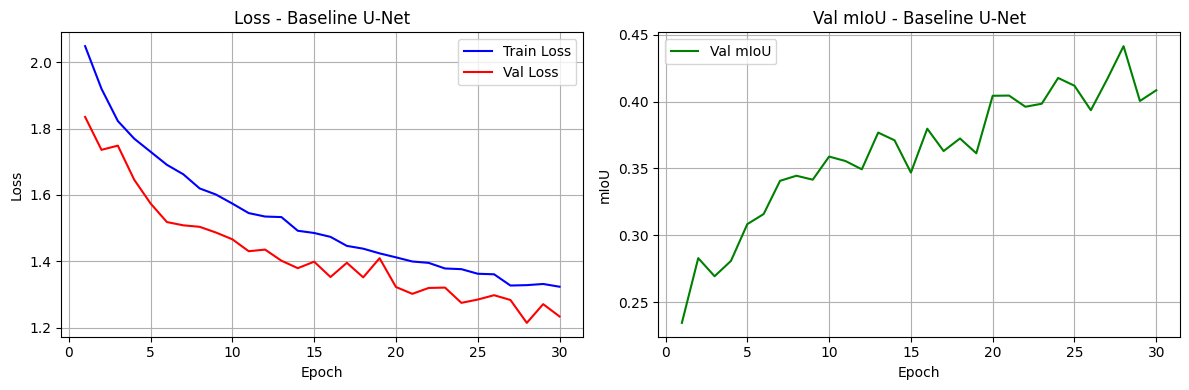

Training curves saved to outputs/unet_baseline/artifacts/training_curves_baseline.png


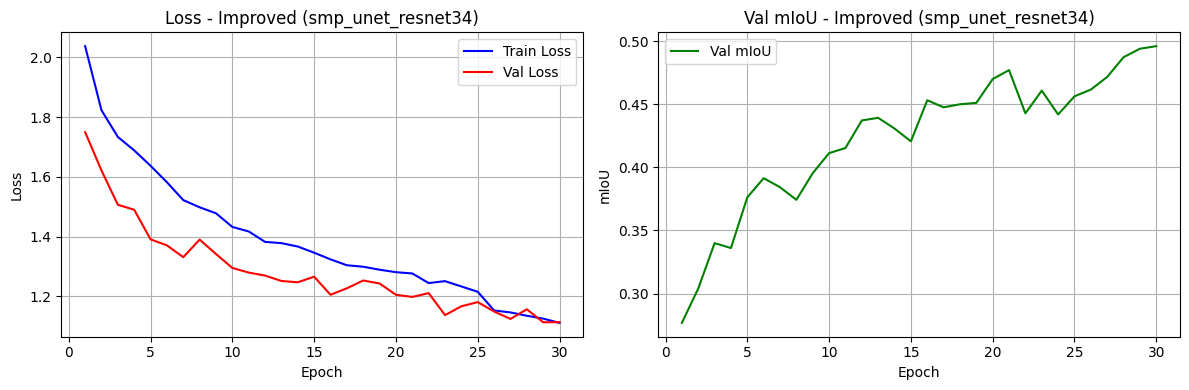

Training curves saved to outputs/model_optionA/artifacts/training_curves_improved.png


In [ ]:
# Plot training curves
if RUN_BASELINE:
    plot_training_curves(
        baseline_history,
        baseline_artifacts_dir / "training_curves_baseline.png",
        title="Baseline U-Net",
    )
if RUN_IMPROVED:
    plot_training_curves(
        improved_history,
        improved_artifacts_dir / "training_curves_improved.png",
        title=f"Improved ({IMPROVED_MODEL})",
    )


**Purpose: Define visualization utilities**
- Visualization section: prepares mask coloring and overlay helpers
- Uses CLASS_COLORS and normalization settings
- Supports qualitative inspection of predictions

Purpose: Defines helper function(s) like `denormalize_image`.
Inputs: none. Outputs: functions available for later use.


In [ ]:
# Visualization helper functions


def denormalize_image(img_tensor, mean=NORM_MEAN, std=NORM_STD):
    """Denormalize image tensor for visualization."""
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    img = torch.clamp(img, 0, 1)
    return img


def _present_ids(mask):
    ids = np.unique(mask)
    if IGNORE_INDEX is not None:
        ids = ids[ids != IGNORE_INDEX]
    return ids.tolist()


def colorize_mask(mask):
    """Convert class index mask to RGB color mask (ignore_index -> black)."""
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
    return encode_ids_to_rgb(mask, CLASS_COLORS, ignore_index=IGNORE_INDEX, ignore_color=(0, 0, 0))


def overlay_mask(image, mask, alpha=0.5):
    colored = colorize_mask(mask).astype(np.float32) / 255.0
    overlay = image * (1 - alpha) + colored * alpha
    return np.clip(overlay, 0, 1)


def visualize_predictions(model, dataloader, device, num_samples=5, save_path=None, has_labels=True):
    """Visualize model predictions."""
    model.eval()

    samples = []
    for batch in dataloader:
        samples.append(batch)
        if len(samples) * batch["image"].shape[0] >= num_samples:
            break

    num_cols = 4 if has_labels else 3
    fig, axes = plt.subplots(num_samples, num_cols, figsize=(4 * num_cols, 4 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        sample_idx = 0
        for batch in samples:
            images = batch["image"].to(device)
            outputs = model_forward(model, images)
            preds = torch.argmax(outputs, dim=1)

            batch_size = images.shape[0]
            for j in range(batch_size):
                if sample_idx >= num_samples:
                    break

                img = denormalize_image(images[j])
                img_np = img.permute(1, 2, 0).cpu().numpy()
                pred_np = preds[j].cpu().numpy()

                axes[sample_idx, 0].imshow(img_np)
                axes[sample_idx, 0].set_title(f"RGB Image\n{batch['filename'][j]}")
                axes[sample_idx, 0].axis("off")

                col_idx = 1
                if has_labels and "label" in batch:
                    gt_np = batch["label"][j].numpy()
                    axes[sample_idx, col_idx].imshow(colorize_mask(gt_np), interpolation="nearest")
                    axes[sample_idx, col_idx].set_title("Ground Truth (CLASS_COLORS)")
                    axes[sample_idx, col_idx].axis("off")
                    make_legend(axes[sample_idx, col_idx], CLASS_NAMES, CLASS_COLORS, present_ids=_present_ids(gt_np))
                    col_idx += 1

                axes[sample_idx, col_idx].imshow(colorize_mask(pred_np), interpolation="nearest")
                axes[sample_idx, col_idx].set_title("Prediction (CLASS_COLORS)")
                axes[sample_idx, col_idx].axis("off")
                make_legend(axes[sample_idx, col_idx], CLASS_NAMES, CLASS_COLORS, present_ids=_present_ids(pred_np))
                col_idx += 1

                overlay = overlay_mask(img_np, pred_np)
                axes[sample_idx, col_idx].imshow(overlay, interpolation="nearest")
                axes[sample_idx, col_idx].set_title("Overlay")
                axes[sample_idx, col_idx].axis("off")

                sample_idx += 1

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Predictions saved to {save_path}")
    plt.show()



def visualize_detailed_outputs(model, dataloader, device, num_samples=3, output_dir=None, tag="run"):
    model.eval()
    samples = []
    for batch in dataloader:
        samples.append(batch)
        if len(samples) * batch["image"].shape[0] >= num_samples:
            break

    def _plot_grid(title, rows, save_path):
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        for i, (img_np, mask_rgb, overlay, present_ids) in enumerate(rows):
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title("RGB Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(mask_rgb, interpolation="nearest")
            axes[i, 1].set_title(title)
            axes[i, 1].axis("off")
            make_legend(axes[i, 1], CLASS_NAMES, CLASS_COLORS, present_ids=present_ids)

            axes[i, 2].imshow(overlay, interpolation="nearest")
            axes[i, 2].set_title("Overlay")
            axes[i, 2].axis("off")
            make_legend(axes[i, 2], CLASS_NAMES, CLASS_COLORS, present_ids=present_ids)

        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, dpi=150, bbox_inches="tight")
            print(f"Saved {title} grid to {save_path}")
        plt.show()

    gt_rows = []
    pred_rows = []
    compare_rows = []

    with torch.no_grad():
        sample_idx = 0
        for batch in samples:
            images = batch["image"].to(device)
            outputs = model_forward(model, images)
            preds = torch.argmax(outputs, dim=1)

            batch_size = images.shape[0]
            for j in range(batch_size):
                if sample_idx >= num_samples:
                    break

                img = denormalize_image(images[j])
                img_np = img.permute(1, 2, 0).cpu().numpy()
                pred_np = preds[j].cpu().numpy()

                gt_np = None
                if "label" in batch:
                    gt_np = batch["label"][j].numpy()

                if gt_np is not None:
                    gt_rgb = colorize_mask(gt_np)
                    gt_overlay = overlay_mask(img_np, gt_np)
                    gt_rows.append((img_np, gt_rgb, gt_overlay, _present_ids(gt_np)))

                pred_rgb = colorize_mask(pred_np)
                pred_overlay = overlay_mask(img_np, pred_np)
                pred_rows.append((img_np, pred_rgb, pred_overlay, _present_ids(pred_np)))

                if gt_np is not None:
                    compare_rows.append((img_np, gt_overlay, pred_overlay, _present_ids(gt_np), _present_ids(pred_np)))

                sample_idx += 1

    if output_dir is not None:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

    if gt_rows:
        _plot_grid(
            "Ground Truth (CLASS_COLORS)",
            gt_rows,
            None if output_dir is None else output_dir / f"{tag}_gt_overlay.png",
        )

    _plot_grid(
        "Prediction (CLASS_COLORS)",
        pred_rows,
        None if output_dir is None else output_dir / f"{tag}_pred_overlay.png",
    )

    if compare_rows:
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        for i, (img_np, gt_overlay, pred_overlay, present_gt, present_pred) in enumerate(compare_rows):
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title("RGB Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(gt_overlay, interpolation="nearest")
            axes[i, 1].set_title("GT Overlay")
            axes[i, 1].axis("off")
            make_legend(axes[i, 1], CLASS_NAMES, CLASS_COLORS, present_ids=present_gt)

            axes[i, 2].imshow(pred_overlay, interpolation="nearest")
            axes[i, 2].set_title("Pred Overlay")
            axes[i, 2].axis("off")
            make_legend(axes[i, 2], CLASS_NAMES, CLASS_COLORS, present_ids=present_pred)

        plt.tight_layout()
        if output_dir is not None:
            save_path = output_dir / f"{tag}_overlay_compare.png"
            plt.savefig(save_path, dpi=150, bbox_inches="tight")
            print(f"Saved overlay comparison grid to {save_path}")
        plt.show()


def visualize_comparison(baseline_model, improved_model, dataloader, device, num_samples=3, save_path=None):
    """Side-by-side comparison: RGB | GT | Baseline | Improved."""
    baseline_model.eval()
    improved_model.eval()

    samples = []
    for batch in dataloader:
        samples.append(batch)
        if len(samples) * batch["image"].shape[0] >= num_samples:
            break

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        sample_idx = 0
        for batch in samples:
            images = batch["image"].to(device)
            gt = batch.get("label")
            base_logits = model_forward(baseline_model, images)
            imp_logits = model_forward(improved_model, images)
            base_preds = torch.argmax(base_logits, dim=1)
            imp_preds = torch.argmax(imp_logits, dim=1)

            batch_size = images.shape[0]
            for j in range(batch_size):
                if sample_idx >= num_samples:
                    break

                img = denormalize_image(images[j])
                img_np = img.permute(1, 2, 0).cpu().numpy()

                axes[sample_idx, 0].imshow(img_np)
                axes[sample_idx, 0].set_title("RGB")
                axes[sample_idx, 0].axis("off")

                if gt is not None:
                    gt_np = gt[j].numpy()
                    axes[sample_idx, 1].imshow(colorize_mask(gt_np), interpolation="nearest")
                    axes[sample_idx, 1].set_title("GT (CLASS_COLORS)")
                    make_legend(axes[sample_idx, 1], CLASS_NAMES, CLASS_COLORS, present_ids=_present_ids(gt_np))
                else:
                    axes[sample_idx, 1].imshow(img_np)
                    axes[sample_idx, 1].set_title("GT (n/a)")
                axes[sample_idx, 1].axis("off")

                axes[sample_idx, 2].imshow(colorize_mask(base_preds[j].cpu().numpy()), interpolation="nearest")
                axes[sample_idx, 2].set_title("Baseline")
                axes[sample_idx, 2].axis("off")

                axes[sample_idx, 3].imshow(colorize_mask(imp_preds[j].cpu().numpy()), interpolation="nearest")
                axes[sample_idx, 3].set_title("Improved")
                axes[sample_idx, 3].axis("off")

                sample_idx += 1

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Comparison grid saved to {save_path}")
    plt.show()


**Purpose: Visualize baseline model predictions**
- Visualization section: shows images, masks, and overlays for the baseline model
- Uses val_loader and test_loader for qualitative review
- Saves prediction grids to disk

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Visualize baseline predictions
if RUN_BASELINE:
    print("Baseline: validation predictions...")
    visualize_predictions(
        baseline_model,
        val_loader,
        device,
        num_samples=5,
        save_path=baseline_artifacts_dir / "sample_predictions_baseline.png",
        has_labels=True,
    )

    visualize_detailed_outputs(
        baseline_model,
        val_loader,
        device,
        num_samples=QUAL_SAMPLES,
        output_dir=baseline_artifacts_dir,
        tag="baseline_val",
    )

    print("Baseline: test predictions...")
    visualize_predictions(
        baseline_model,
        test_loader,
        device,
        num_samples=5,
        save_path=baseline_artifacts_dir / "sample_predictions_baseline_test.png",
        has_labels=True,
    )

    if infer_test_loader is not None:
        print("Baseline: inference-only test predictions...")
        visualize_predictions(
            baseline_model,
            infer_test_loader,
            device,
            num_samples=5,
            save_path=baseline_artifacts_dir / "sample_predictions_baseline_infer_test.png",
            has_labels=False,
        )


Output hidden; open in https://colab.research.google.com to view.

**Purpose: Visualize improved predictions and comparisons**
- Visualization section: generates improved-model grids and side-by-side comparisons
- Uses both models to highlight qualitative differences
- Saves comparison figures to disk

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Visualize improved predictions and side-by-side comparison
if RUN_IMPROVED:
    print("Improved: validation predictions...")
    visualize_predictions(
        improved_model,
        val_loader,
        device,
        num_samples=5,
        save_path=improved_artifacts_dir / "sample_predictions_improved.png",
        has_labels=True,
    )

    visualize_detailed_outputs(
        improved_model,
        val_loader,
        device,
        num_samples=QUAL_SAMPLES,
        output_dir=improved_artifacts_dir,
        tag="improved_val",
    )

    print("Improved: test predictions...")
    visualize_predictions(
        improved_model,
        test_loader,
        device,
        num_samples=5,
        save_path=improved_artifacts_dir / "sample_predictions_improved_test.png",
        has_labels=True,
    )

    if infer_test_loader is not None:
        print("Improved: inference-only test predictions...")
        visualize_predictions(
            improved_model,
            infer_test_loader,
            device,
            num_samples=5,
            save_path=improved_artifacts_dir / "sample_predictions_improved_infer_test.png",
            has_labels=False,
        )

if RUN_BASELINE and RUN_IMPROVED:
    visualize_comparison(
        baseline_model,
        improved_model,
        val_loader,
        device,
        num_samples=QUAL_SAMPLES,
        save_path=compare_dir / "qualitative_comparison.png",
    )


Output hidden; open in https://colab.research.google.com to view.

## F2) Environmental Monitoring: Change Detection (Vegetation & Water Levels)
We estimate change by comparing segmentation masks at t1 vs t2.

- Water level proxy: change in water surface area (percent of pixels).
- Vegetation proxy: change in combined vegetation classes (percent of pixels).
- OpenEarthMap is not time-paired, so we demonstrate with synthetic before/after pairs created via controlled mask perturbations.


**Purpose: Demonstrate synthetic change detection**
- Change detection section: creates synthetic before/after masks and coverage deltas
- Uses val_loader, CLASS_NAMES, and available models for GT/predicted comparisons
- Saves change tables and visualizations

Purpose: Imports required libraries and utilities.
Inputs: none. Outputs: modules available for later cells.


Water class index: 5
Vegetation class indices: [4, 1, 6]
Saved GT change table to outputs/change_detection/change_gt.csv
Saved predicted change table to outputs/change_detection/change_pred.csv


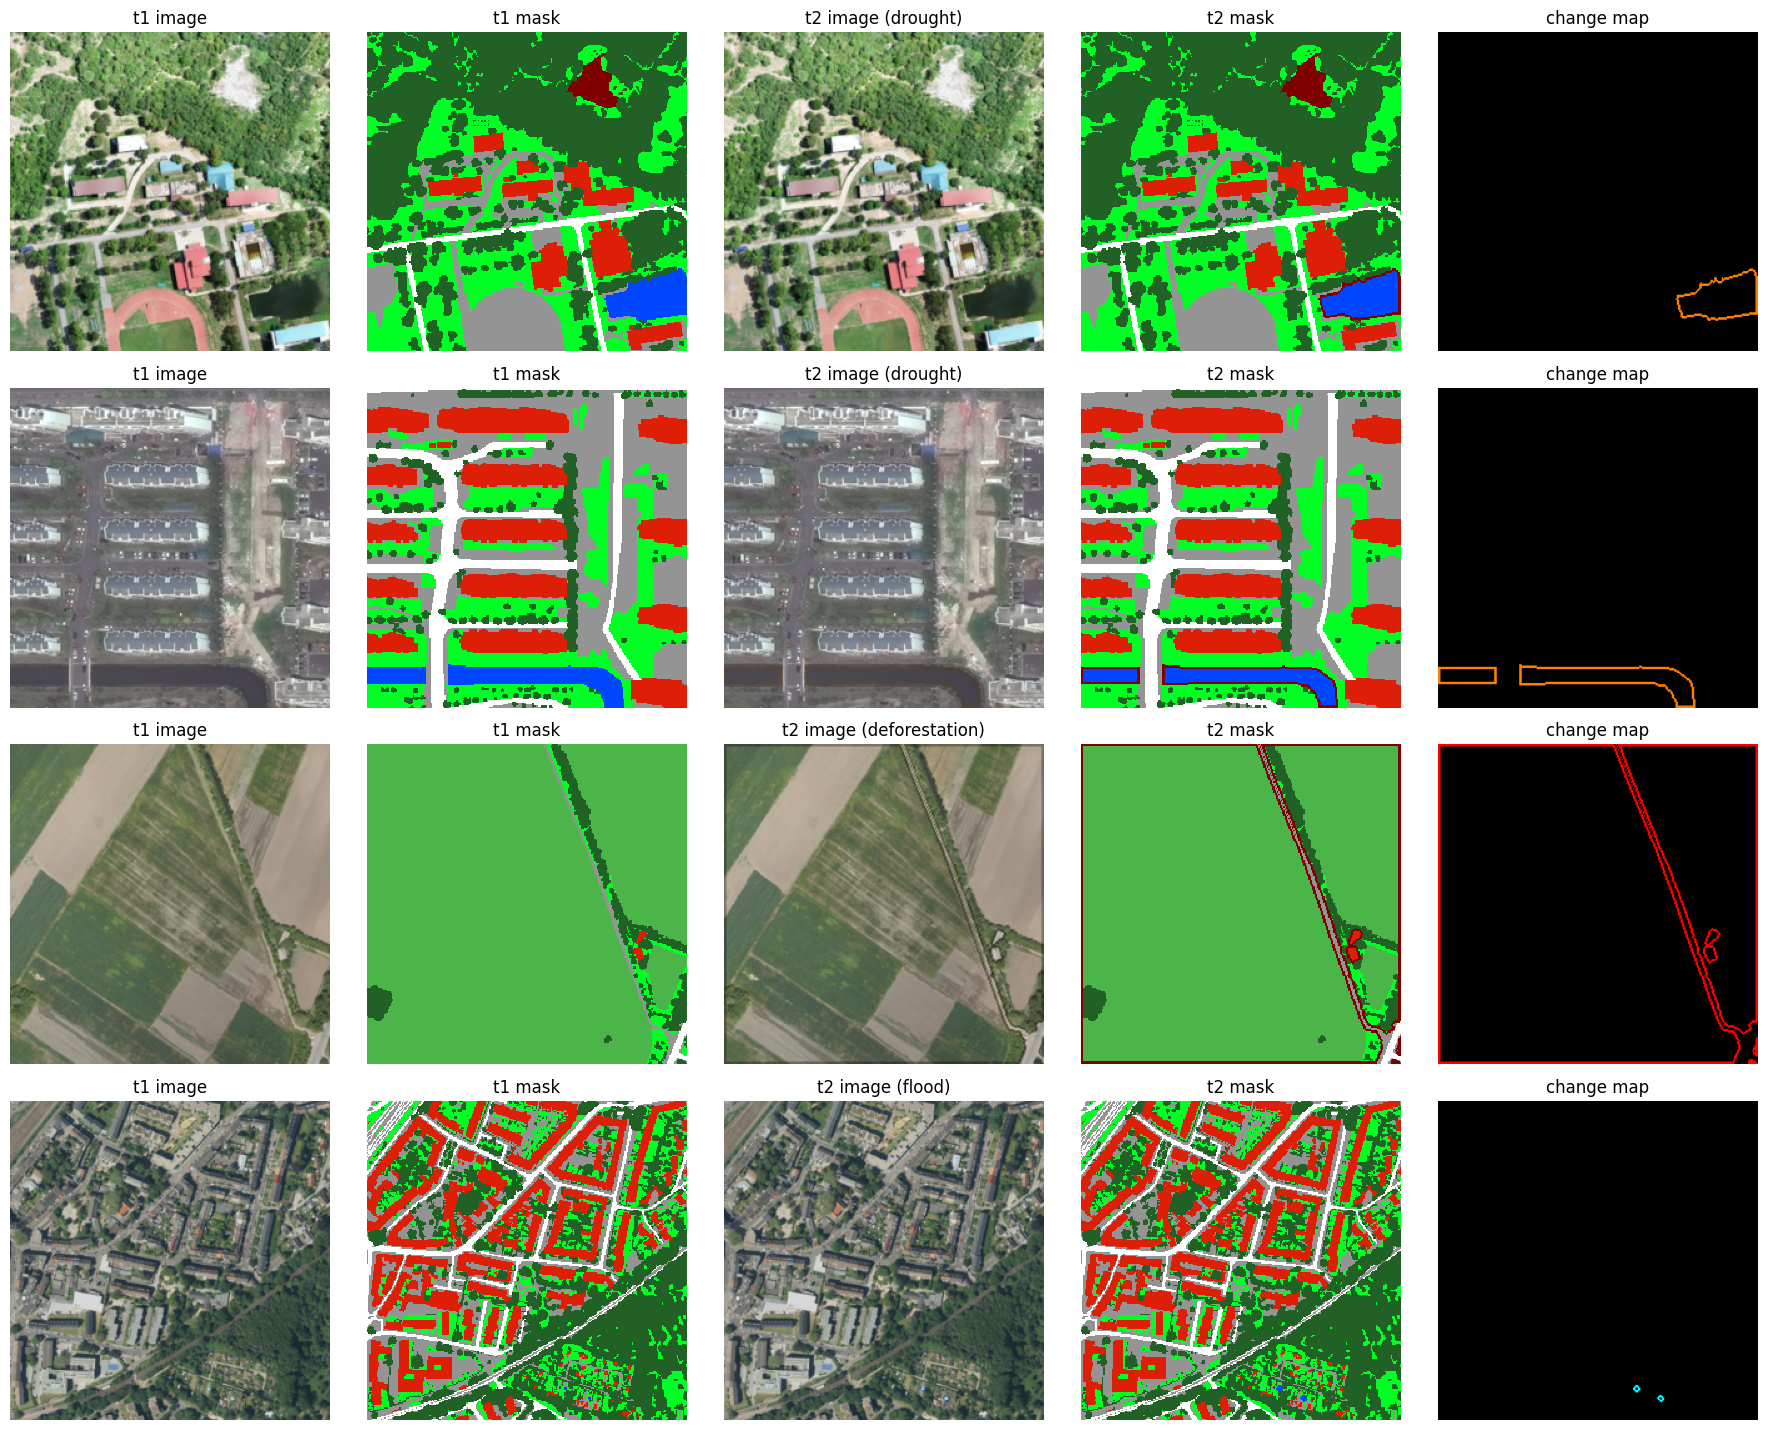

Saved change examples to outputs/change_detection/change_examples.png


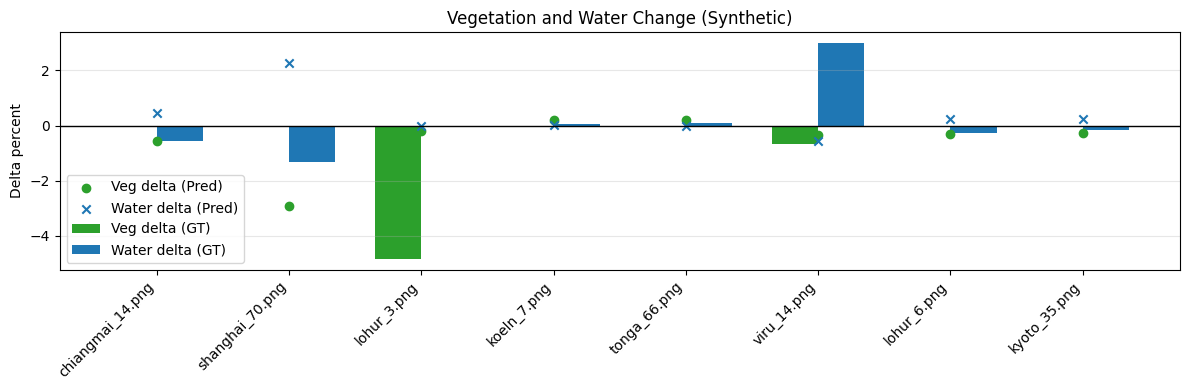

Saved change deltas plot to outputs/change_detection/change_deltas.png
GT mean delta veg: -0.690%
GT mean delta water: 0.105%
Pred mean delta veg: -0.527%
Pred mean delta water: 0.335%


In [ ]:
# Change detection helpers and demo
import numpy as np

try:
    import pandas as pd
except Exception:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "pandas"])
    import pandas as pd

change_dir = OUTPUTS_DIR / "change_detection"
change_dir.mkdir(parents=True, exist_ok=True)


def _class_index(name):
    return CLASS_NAMES.index(name) if name in CLASS_NAMES else None


WATER_CLASS = _class_index("Water")
VEGETATION_CLASSES = [
    _class_index(name)
    for name in ["Tree", "Rangeland", "Agriculture"]
    if name in CLASS_NAMES
]
BARELAND_CLASS = _class_index("Bareland")

print(f"Water class index: {WATER_CLASS}")
print(f"Vegetation class indices: {VEGETATION_CLASSES}")

try:
    from scipy.ndimage import binary_dilation, binary_erosion
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False


def _binary_dilate(mask, iterations=1):
    if HAVE_SCIPY:
        return binary_dilation(mask, iterations=iterations)
    m = torch.from_numpy(mask.astype(np.float32))[None, None]
    kernel = torch.ones((1, 1, 3, 3), dtype=torch.float32)
    for _ in range(iterations):
        conv = F.conv2d(m, kernel, padding=1)
        m = (conv > 0).float()
    return m[0, 0].cpu().numpy().astype(bool)


def _binary_erode(mask, iterations=1):
    if HAVE_SCIPY:
        return binary_erosion(mask, iterations=iterations)
    m = torch.from_numpy(mask.astype(np.float32))[None, None]
    kernel = torch.ones((1, 1, 3, 3), dtype=torch.float32)
    for _ in range(iterations):
        conv = F.conv2d(m, kernel, padding=1)
        m = (conv == kernel.numel()).float()
    return m[0, 0].cpu().numpy().astype(bool)


def compute_coverage(mask_np):
    total = mask_np.size
    veg_pixels = int(np.isin(mask_np, VEGETATION_CLASSES).sum()) if VEGETATION_CLASSES else 0
    water_pixels = int((mask_np == WATER_CLASS).sum()) if WATER_CLASS is not None else 0
    veg_ratio = veg_pixels / total if total > 0 else 0.0
    water_ratio = water_pixels / total if total > 0 else 0.0
    return veg_ratio, water_ratio, veg_pixels, water_pixels, total


def make_synthetic_after_mask(mask_np, mode, iterations=2):
    new_mask = mask_np.copy()
    if WATER_CLASS is None or not VEGETATION_CLASSES:
        return new_mask

    if mode in ["drought", "flood"]:
        water_mask = mask_np == WATER_CLASS
        if mode == "drought":
            eroded = _binary_erode(water_mask, iterations=iterations)
            removed = water_mask & ~eroded
            if removed.any() and BARELAND_CLASS is not None:
                new_mask[removed] = BARELAND_CLASS
        else:
            dilated = _binary_dilate(water_mask, iterations=iterations)
            added = dilated & ~water_mask
            new_mask[added] = WATER_CLASS
        return new_mask

    veg_mask = np.isin(mask_np, VEGETATION_CLASSES)
    if mode == "deforestation":
        eroded = _binary_erode(veg_mask, iterations=iterations)
        removed = veg_mask & ~eroded
        if removed.any() and BARELAND_CLASS is not None:
            new_mask[removed] = BARELAND_CLASS
        return new_mask

    if mode == "regrowth":
        dilated = _binary_dilate(veg_mask, iterations=iterations)
        added = dilated & ~veg_mask
        veg_fill = _class_index("Tree") if "Tree" in CLASS_NAMES else VEGETATION_CLASSES[0]
        if veg_fill is not None:
            new_mask[added] = veg_fill
    return new_mask


def apply_synthetic_visual_change(image_np, t1_mask, t2_mask):
    img = image_np.copy()
    if WATER_CLASS is None or not VEGETATION_CLASSES:
        return img

    veg_t1 = np.isin(t1_mask, VEGETATION_CLASSES)
    veg_t2 = np.isin(t2_mask, VEGETATION_CLASSES)
    water_t1 = t1_mask == WATER_CLASS
    water_t2 = t2_mask == WATER_CLASS

    veg_loss = veg_t1 & ~veg_t2
    veg_gain = ~veg_t1 & veg_t2
    water_gain = ~water_t1 & water_t2
    water_loss = water_t1 & ~water_t2

    img[veg_loss] = img[veg_loss] * 0.7
    img[veg_gain, 1] = np.clip(img[veg_gain, 1] + 0.1, 0, 1)

    img[water_gain, 2] = np.clip(img[water_gain, 2] + 0.2, 0, 1)
    img[water_gain, 0] = img[water_gain, 0] * 0.9
    img[water_loss, 2] = img[water_loss, 2] * 0.7
    img[water_loss, 0] = np.clip(img[water_loss, 0] + 0.05, 0, 1)

    return np.clip(img, 0, 1)


def normalize_image_np(image_np, mean=NORM_MEAN, std=NORM_STD):
    img = image_np.astype(np.float32)
    mean = np.array(mean, dtype=np.float32)
    std = np.array(std, dtype=np.float32)
    img = (img - mean) / std
    tensor = torch.from_numpy(img).permute(2, 0, 1).float()
    return tensor


def build_change_map(t1_mask, t2_mask):
    h, w = t1_mask.shape
    change = np.zeros((h, w, 3), dtype=np.float32)
    if WATER_CLASS is None or not VEGETATION_CLASSES:
        return change

    veg_t1 = np.isin(t1_mask, VEGETATION_CLASSES)
    veg_t2 = np.isin(t2_mask, VEGETATION_CLASSES)
    water_t1 = t1_mask == WATER_CLASS
    water_t2 = t2_mask == WATER_CLASS

    veg_loss = veg_t1 & ~veg_t2
    veg_gain = ~veg_t1 & veg_t2
    water_loss = water_t1 & ~water_t2
    water_gain = ~water_t1 & water_t2

    change[veg_loss] = [1.0, 0.0, 0.0]
    change[veg_gain] = [0.0, 1.0, 0.0]
    change[water_loss] = [1.0, 0.5, 0.0]
    change[water_gain] = [0.0, 1.0, 1.0]
    return change


# Collect samples from validation set
N_SAMPLES = 8
modes = ["drought", "flood", "deforestation", "regrowth"]
rng = random.Random(SEED)

samples = []
for batch in val_loader:
    images = batch["image"]
    labels = batch["label"]
    filenames = batch["filename"]
    for i in range(images.shape[0]):
        samples.append(
            {
                "image": images[i].cpu(),
                "label": labels[i].cpu().numpy(),
                "filename": filenames[i],
            }
        )
        if len(samples) >= N_SAMPLES:
            break
    if len(samples) >= N_SAMPLES:
        break

if not samples:
    print("No samples available for change detection.")

# GT-based synthetic changes
change_gt_rows = []
visual_examples = []
for idx, sample in enumerate(samples):
    t1_mask = sample["label"]
    mode = rng.choice(modes)
    t2_mask = make_synthetic_after_mask(t1_mask, mode)

    veg_before, water_before, _, _, _ = compute_coverage(t1_mask)
    veg_after, water_after, _, _, _ = compute_coverage(t2_mask)

    row = {
        "sample_id": sample["filename"],
        "mode": mode,
        "veg_before_pct": veg_before * 100.0,
        "veg_after_pct": veg_after * 100.0,
        "delta_veg_pct": (veg_after - veg_before) * 100.0,
        "water_before_pct": water_before * 100.0,
        "water_after_pct": water_after * 100.0,
        "delta_water_pct": (water_after - water_before) * 100.0,
    }
    change_gt_rows.append(row)

    t1_img = denormalize_image(sample["image"]).permute(1, 2, 0).numpy()
    t2_img = apply_synthetic_visual_change(t1_img, t1_mask, t2_mask)

    sample["mode"] = mode
    sample["t2_mask"] = t2_mask
    sample["t2_img"] = t2_img

    if len(visual_examples) < 4:
        visual_examples.append(
            {
                "t1_img": t1_img,
                "t2_img": t2_img,
                "t1_mask": t1_mask,
                "t2_mask": t2_mask,
                "mode": mode,
            }
        )

change_gt_df = pd.DataFrame(change_gt_rows)
change_gt_path = change_dir / "change_gt.csv"
change_gt_df.to_csv(change_gt_path, index=False)
print(f"Saved GT change table to {change_gt_path}")

# Model-based change detection
change_pred_df = None
model_for_change = None
model_name = None

if RUN_IMPROVED:
    model_for_change = improved_model
    model_name = "improved_model"
elif RUN_BASELINE:
    model_for_change = baseline_model
    model_name = "baseline_model"

if model_for_change is None:
    print("Skipping predicted change detection (no model available).")
else:
    model_for_change.eval()
    change_pred_rows = []
    with torch.no_grad():
        for sample in samples:
            t1_tensor = sample["image"].unsqueeze(0).to(device)
            t1_logits = model_forward(model_for_change, t1_tensor)
            t1_pred = torch.argmax(t1_logits, dim=1)[0].cpu().numpy()

            t2_tensor = normalize_image_np(sample["t2_img"]).unsqueeze(0).to(device)
            t2_logits = model_forward(model_for_change, t2_tensor)
            t2_pred = torch.argmax(t2_logits, dim=1)[0].cpu().numpy()

            veg_before, water_before, _, _, _ = compute_coverage(t1_pred)
            veg_after, water_after, _, _, _ = compute_coverage(t2_pred)

            change_pred_rows.append(
                {
                    "sample_id": sample["filename"],
                    "mode": sample["mode"],
                    "veg_before_pct": veg_before * 100.0,
                    "veg_after_pct": veg_after * 100.0,
                    "delta_veg_pct": (veg_after - veg_before) * 100.0,
                    "water_before_pct": water_before * 100.0,
                    "water_after_pct": water_after * 100.0,
                    "delta_water_pct": (water_after - water_before) * 100.0,
                    "model": model_name,
                }
            )

    change_pred_df = pd.DataFrame(change_pred_rows)
    change_pred_path = change_dir / "change_pred.csv"
    change_pred_df.to_csv(change_pred_path, index=False)
    print(f"Saved predicted change table to {change_pred_path}")

# Visualization grid for a few examples (GT-based)
if visual_examples:
    rows = len(visual_examples)
    fig, axes = plt.subplots(rows, 5, figsize=(18, 3.6 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, ex in enumerate(visual_examples):
        axes[i, 0].imshow(ex["t1_img"])
        axes[i, 0].set_title("t1 image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(colorize_mask(ex["t1_mask"]), interpolation="nearest")
        axes[i, 1].set_title("t1 mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(ex["t2_img"])
        axes[i, 2].set_title(f"t2 image ({ex['mode']})")
        axes[i, 2].axis("off")

        axes[i, 3].imshow(colorize_mask(ex["t2_mask"]), interpolation="nearest")
        axes[i, 3].set_title("t2 mask")
        axes[i, 3].axis("off")

        change_map = build_change_map(ex["t1_mask"], ex["t2_mask"])
        axes[i, 4].imshow(change_map)
        axes[i, 4].set_title("change map")
        axes[i, 4].axis("off")

    plt.tight_layout()
    change_examples_path = change_dir / "change_examples.png"
    plt.savefig(change_examples_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved change examples to {change_examples_path}")

# Delta plot for all samples
if not change_gt_df.empty:
    fig, ax = plt.subplots(figsize=(12, 4))
    x = np.arange(len(change_gt_df))
    width = 0.35

    ax.bar(
        x - width / 2,
        change_gt_df["delta_veg_pct"],
        width,
        label="Veg delta (GT)",
        color="#2ca02c",
    )
    ax.bar(
        x + width / 2,
        change_gt_df["delta_water_pct"],
        width,
        label="Water delta (GT)",
        color="#1f77b4",
    )

    if change_pred_df is not None and not change_pred_df.empty:
        ax.scatter(
            x,
            change_pred_df["delta_veg_pct"],
            color="#2ca02c",
            marker="o",
            label="Veg delta (Pred)",
        )
        ax.scatter(
            x,
            change_pred_df["delta_water_pct"],
            color="#1f77b4",
            marker="x",
            label="Water delta (Pred)",
        )

    ax.axhline(0, color="black", linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(change_gt_df["sample_id"], rotation=45, ha="right")
    ax.set_ylabel("Delta percent")
    ax.set_title("Vegetation and Water Change (Synthetic)")
    ax.legend()
    ax.grid(True, axis="y", alpha=0.3)

    plt.tight_layout()
    change_deltas_path = change_dir / "change_deltas.png"
    plt.savefig(change_deltas_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved change deltas plot to {change_deltas_path}")

# Summary statistics
if not change_gt_df.empty:
    gt_mean_veg = change_gt_df["delta_veg_pct"].mean()
    gt_mean_water = change_gt_df["delta_water_pct"].mean()
    print(f"GT mean delta veg: {gt_mean_veg:.3f}%")
    print(f"GT mean delta water: {gt_mean_water:.3f}%")

if change_pred_df is not None and not change_pred_df.empty:
    pred_mean_veg = change_pred_df["delta_veg_pct"].mean()
    pred_mean_water = change_pred_df["delta_water_pct"].mean()
    print(f"Pred mean delta veg: {pred_mean_veg:.3f}%")
    print(f"Pred mean delta water: {pred_mean_water:.3f}%")


## G) Export Results

**Purpose: Summarize output locations**
- Export results section: prints where artifacts are saved
- Uses OUTPUTS_DIR and model output folders

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Export results summary
print("Outputs saved to:")
print(f"  Baseline: {baseline_dir}")
print(f"  Improved: {improved_dir}")
print(f"  Comparison: {compare_dir}")


Outputs saved to:
  Baseline: outputs/unet_baseline
  Improved: outputs/model_optionA
  Comparison: outputs/comparison


**Purpose: Report comparison metrics**
- Export results section: prints validation comparison rows
- Points to saved metrics CSV/JSON files

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Print comparison table
if comparison_rows:
    print("\nComparison table (validation):")
    for row in comparison_rows:
        print(row)
    print(f"Metrics CSV: {compare_dir / 'metrics_val.csv'}")
    print(f"Metrics JSON: {compare_dir / 'metrics_val.json'}")



Comparison table (validation):
{'model': 'baseline_unet', 'val_miou': 0.44155146987912186, 'val_fw_iou': 0.47989442855026154, 'val_pixel_acc': 0.6385480989281044, 'macro_f1': 0.601364113539735, 'macro_precision': 0.5824255078327052, 'macro_recall': 0.65722404218637, 'macro_dice': 0.601364113539735, 'water_iou': 0.39740577309645175, 'vegetation_iou': 0.8135283922843667, 'params': 31043976, 'best_epoch': 28}
{'model': 'improved_model', 'val_miou': 0.49612645586019355, 'val_fw_iou': 0.5098789530327063, 'val_pixel_acc': 0.6691419967821091, 'macro_f1': 0.6511874411927014, 'macro_precision': 0.6359511299569217, 'macro_recall': 0.6785328354180282, 'macro_dice': 0.6511874411927014, 'water_iou': 0.6045169182743048, 'vegetation_iou': 0.843250526668034, 'params': 24437384, 'best_epoch': 30}
Metrics CSV: outputs/comparison/metrics_val.csv
Metrics JSON: outputs/comparison/metrics_val.json


**Purpose: Report run configuration paths**
- Export results section: outputs paths to run_config.json files
- Supports reproducibility documentation

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Run configuration files
if RUN_BASELINE:
    print(f"Baseline run config: {baseline_dir / 'run_config.json'}")
if RUN_IMPROVED:
    print(f"Improved run config: {improved_dir / 'run_config.json'}")


Baseline run config: outputs/unet_baseline/run_config.json
Improved run config: outputs/model_optionA/run_config.json


**Purpose: Report key artifact directories**
- Export results section: lists checkpoint and artifact folders
- Confirms where outputs are stored

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
# Key artifacts
if RUN_BASELINE:
    print(f"Baseline checkpoints: {baseline_ckpt_dir}")
    print(f"Baseline artifacts: {baseline_artifacts_dir}")
if RUN_IMPROVED:
    print(f"Improved checkpoints: {improved_ckpt_dir}")
    print(f"Improved artifacts: {improved_artifacts_dir}")
print(f"Comparison artifacts: {compare_dir}")


Baseline checkpoints: outputs/unet_baseline/checkpoints
Baseline artifacts: outputs/unet_baseline/artifacts
Improved checkpoints: outputs/model_optionA/checkpoints
Improved artifacts: outputs/model_optionA/artifacts
Comparison artifacts: outputs/comparison


## Final Summary

**Purpose: Print final training summary**
- Final summary section: reports key training and evaluation metrics
- Uses recorded histories and computed metrics for the run

Purpose: Runs a workflow step and updates notebook state.
Inputs: variables/files defined above. Outputs: updated variables, artifacts, or printed status.


In [ ]:
print("=" * 80)
print("TRAINING COMPLETE")
print("=" * 80)
if RUN_BASELINE:
    print("Baseline (U-Net):")
    print(f"  Params: {baseline_total_params:,}")
    if baseline_train_results:
        print(f"  Best epoch: {baseline_train_results['best_epoch']}")
        print(f"  Best Val mIoU: {baseline_train_results['best_miou']:.4f}")
    if baseline_metrics:
        print(f"  Val mIoU: {baseline_metrics['miou']:.4f}")
        print(f"  Pixel Accuracy: {baseline_metrics['pixel_acc']:.4f}")

if RUN_IMPROVED:
    print("Improved:")
    print(f"  Params: {improved_total_params:,}")
    if improved_train_results:
        print(f"  Best epoch: {improved_train_results['best_epoch']}")
        print(f"  Best Val mIoU: {improved_train_results['best_miou']:.4f}")
    if improved_metrics:
        print(f"  Val mIoU: {improved_metrics['miou']:.4f}")
        print(f"  Pixel Accuracy: {improved_metrics['pixel_acc']:.4f}")

print(f"\nOutputs root: {OUTPUTS_DIR}")
print(f"Comparison summary: {compare_dir / 'summary.md'}")
print("=" * 80)


TRAINING COMPLETE
Baseline (U-Net):
  Params: 31,043,976
  Best epoch: 28
  Best Val mIoU: 0.4416
  Val mIoU: 0.4416
  Pixel Accuracy: 0.6385
Improved:
  Params: 24,437,384
  Best epoch: 30
  Best Val mIoU: 0.4961
  Val mIoU: 0.4961
  Pixel Accuracy: 0.6691

Outputs root: outputs
Comparison summary: outputs/comparison/summary.md
